# Dataset analysis

This notebook is used to analyze two-photon data from a single dataset (i.e., mouse, experiment, date) across conditions and trials.

### Acquisition protocols & raw data

Raw data consist of individual 16-bit deep, 256-by-256 pixels grayscale TIF images of GCaMP6s fluorescence data acquired at a sampling rate of 3.56 Hz and spatial resolution of 1.97 μm / pixel by the Bruker microscope during experiments.

Each acquisition protocol (or run) consists of 16 sonication trials with an inter sonication interval of approximately 30s.

Each trial is divided in 2 cycles:
- The first cycle (indicated by an odd number) consists of 10 frames of the pre-stimulus interval of the trial (ca. 2.8s).
- The second cycle (indicated by an even number) consists of 90 frames of the peri and post-stimulus intervals of the trial (ca. 25.2s).

The ultrasound stimulus is delivered concurrently with the acquisition of the 10th frame of the first cycle (i.e. ca. at t = 2.8s).

The TIF images from a given run are all stored in a single folder, which is named according to a specific pattern depending on the specimen, stimulation and acquisitation parameters:

`foldername = <mouse_line>_<nframes_per_trial>frames_<PRF>Hz_<stim_duration>ms_<sampling_rate>Hz_<stim_amplitude>MPA_<stim_DC>DC-<run_ID>`

Inside this folder, individual files are named using this same pattern, together with unique cycle and frame identifers:

`filename = <foldername>_Cycle<cycle_number>_Ch2_<frame_number>.ome.tif`

This informative nomenclature is used as a way to store metadata associated with each experimental run.

Additionally, a file named `<foldername>.xml`, containing information about the microscope acquisition parameters for the run, is also stored in the data folder.

### Processing pipeline

The analysis consists of several successive steps:
1. Pre-processing of raw movie frames
2. Functional segmentation with suite2p
3. Post-processing (i.e. computation of ΔF/F0 and z-score signals)
4. Statistics (data curation, extraction of response metrics & cell classification)
5. Visualization of analysis outputs

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime
from scipy.stats import skew

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from filters import KalmanDenoiser
from substitutors import StackSubstitutor
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

## Parameters

### Input & output directories

In [3]:
dataroot = get_data_root()  # Root directory for raw data
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')  # Directory for output figures
logger.info(f'input data root: "{dataroot}"')
logger.info(f'output figures directory: "{figsdir}"')
figs = {}  # Figures dictionary

 04/12/2022 20:13:27: input data root: "/gpfs/scratch/lemait01/data/usnm/raw"
 04/12/2022 20:13:27: output figures directory: "/gpfs/scratch/lemait01/data/usnm/figs/"


### Input dataset and main processing parameters

In [4]:
analysis_type = DEFAULT_ANALYSIS  # analysis type
mouseline = 'sst' #'line3'  # mouse line
expdate = '20190808' # '20191112'  # experiment date
mouseid = 'mouse6' #'mouse12'  # mouse number
region = 'region1'  # brain region
layer = DEFAULT_LAYER  # cortical layer
inspect = True  # whether to inspect data for a randomly chosen run along processing steps
slack_notify = False   # notify start and completion on slack
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
ykey_classification = Label.DFF  # Reference variable for response classification
um_per_px = None  # Spatial resolution of the microscope FOV (um/pixel)

### Derived parameters

In [5]:
# Construct dataset ID
dataset_id = f'{expdate}_{mouseid}_{region}'
if layer != DEFAULT_LAYER:
    dataset_id = f'{dataset_id}_{layer}'

# Construct post-processing ID
baseline_id = ''
if baseline_wquantile is None:
    baseline_wsmoothing = None
else:
    baseline_id = f'wq{baseline_wquantile:.1f}s'
if baseline_wsmoothing is not None:
    baseline_id = f'{baseline_id}_ws{baseline_wsmoothing:.2f}s'
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
baseline_id = f'q{baseline_quantile_str}_{baseline_id}'
postpro_id = f'alpha{neuropil_scaling_coeff}_{baseline_id}'
stats_id = f'class{ykey_classification.replace("/", "")}'

# Extract input data directory
datadir = os.path.join(dataroot, analysis_type, mouseline, dataset_id)
if not os.path.exists:
    raise ValueError(f'input data directory "{datadir}" does not exist')
logger.info(f'input data directory: "{datadir}"')

# Extract figures suffix
figssuffix = f'{mouseline}_{dataset_id}_k{kalman_gain}_{postpro_id}_{stats_id}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_id} notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 04/12/2022 20:13:29: input data directory: "/gpfs/scratch/lemait01/data/usnm/raw/main/sst/20190808_mouse6_region1"
 04/12/2022 20:13:29: 20190808_mouse6_region1 notebook started on 2022-12-04 at 20:13:29


### Input summary table figure

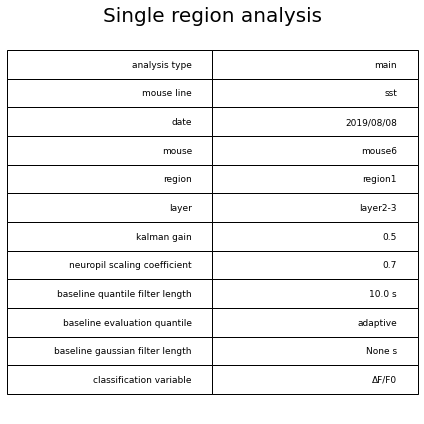

In [6]:
figs['dataset_info'] = plot_table({
    'analysis type': analysis_type,
    'mouse line': mouseline,
    'date': f'{expdate[:4]}/{expdate[4:6]}/{expdate[6:]}',
    'mouse': mouseid,
    'region': region,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification
    }, title='Single region analysis')

### Intermediate data inspection

In [7]:
nROIs_inspect = 3  # number of ROIs to look at for the inspection run (if specified)
stackdict = None  # empty stacks dictionary
runbounds = None  # empty runbounds array
istimframes_stacked = None  # empty stimulus frames array
save_gifs = False  # whether to save gifs of extracted movies or not
qref = 'q0.1'  # reference quantile code 

## Pre-processing (stacking, substitution, denoising)

### Gather data folders & extract acquisition settings

In [8]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(
    datadir, 
    exclude_patterns=['MIP', 'References', 'incomplete', 'duplicated'], 
    include_patterns=[mouseline])
tif_folders_str = '\n'.join([f'  - {os.path.basename(x)}' for x in tif_folders])
logger.info(f'Identified folders containing TIF files:\n{tif_folders_str}')

# Extract acquisition settings from each run
logger.info('extracting acquisition settings...')
daq_settings = parse_acquisition_settings(tif_folders)
um_per_px = daq_settings['micronsPerPixel']
DictTable(daq_settings)

 04/12/2022 20:13:33: /gpfs/scratch/lemait01/data/usnm/raw/main/sst/20190808_mouse6_region1
 04/12/2022 20:13:41: Identified folders containing TIF files:
  - sst_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-501
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-497
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-495
  - sst_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-506
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-496
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-500
  - sst_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-503
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-508
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-509
  - sst_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-505
  - sst_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-502
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-507
  - sst_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-504
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-498
  - sst_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-499
 04/12/2022 20:13:41: extracting acquisition settings...


{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (555.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 395.0, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 0.0, 'YAxis': 0.0, 'ZAxis': 0.0},
 'preampFilter': ('Filter750KHz', '0.75 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.3921568627, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rastersPerFrame': 1.0,
 'rotation': 0.0,
 'scanLinePeriod': 0.00109125759200372,
 'twophotonLaserPower': 2570.0,
 'useInterlacedScanPattern': False,
 'xYStageGridIndex': -1.0,
 'xYStageGridXIndex': -1.0,
 'xYStageGridYIndex': -1.0,
 'yAspectExpansion': 1.0,
 'zDevice': 0.0}

### Merge TIFs into stack

Raw TIF images are assembled into stacked TIF files containing all the frames of an entire run. Each resulting stacked TIF file should contain a 1600x256x256 uint16 array and is named after the directory containing the corresponding individual TIF files.

 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-501.tif" already exists
 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-497.tif" already exists
 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-495.tif" already exists
 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-506.tif" already exists
 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-496.tif" already exists
 04/12/2022 20:13:46: "/gpfs/scratch/lemait01/data/usnm/stacked/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-500.tif" already exists
 04/12/202

100%|██████████| 1600/1600 [00:02<00:00, 734.15it/s]

 04/12/2022 20:13:53: intensity range: 55 - 4094
 04/12/2022 20:13:53: adding 16 delimiters



100%|██████████| 1600/1600 [00:02<00:00, 630.62it/s]

 04/12/2022 20:13:56: initializing stack viewer
 04/12/2022 20:13:56: stack size: (1600, 256, 256)
 04/12/2022 20:13:56: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:02<00:00, 704.87it/s]

 04/12/2022 20:13:58: intensity range: 55 - 4094
 04/12/2022 20:13:58: rendering stack view...


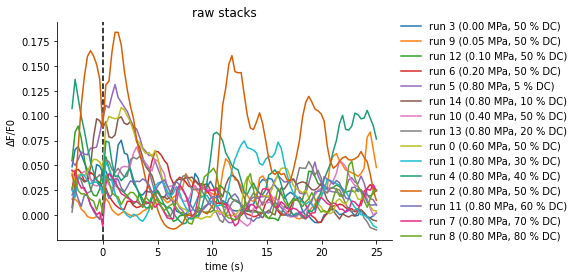

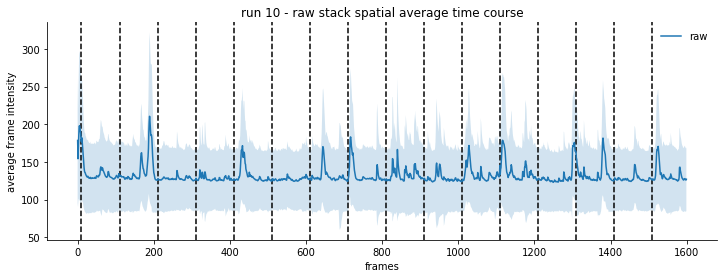

In [9]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Draw inspected run index, if any 
irun_inspect = random.choice(np.arange(nruns)) if inspect else None # run index
stacktitle = f'run {irun_inspect}'  # default stack title

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

figs['trialavg_stackavg_traces raw'] = plot_trialavg_stackavg_traces(
    raw_stack_fpaths, ntrials_per_run, title='raw stacks', iref=qref)

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

### Substitute problematic frames

- stimulation frames are highly polluted by stimulation-evoked noise -> we substitute them by their preceding frames.
- initial frames of each sonicaiton trial also seem problematic -> they are substituted by their following frames

 04/12/2022 20:14:00: all output files already exist -> skipping
 04/12/2022 20:14:00: deriving acoustic intensity information...
 04/12/2022 20:14:03: loading data from sst_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-502.tif
 04/12/2022 20:14:04: loaded (1600, 256, 256) uint16 stack from "/gpfs/scratch/lemait01/data/usnm/substituted/submap0<-1_9->10_every100/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-502.tif"
 04/12/2022 20:14:04: initializing stack viewer
 04/12/2022 20:14:04: stack size: (1600, 256, 256)
 04/12/2022 20:14:04: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:02<00:00, 734.71it/s]

 04/12/2022 20:14:06: intensity range: 55 - 4094



100%|██████████| 1600/1600 [00:02<00:00, 741.11it/s]

 04/12/2022 20:14:08: intensity range: 55 - 4094
 04/12/2022 20:14:08: adding 16 delimiters



100%|██████████| 1600/1600 [00:02<00:00, 650.86it/s]

 04/12/2022 20:14:13: initializing stack viewer
 04/12/2022 20:14:13: stack size: (1600, 256, 256)
 04/12/2022 20:14:13: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:02<00:00, 713.95it/s]

 04/12/2022 20:14:15: intensity range: 55 - 4094



100%|██████████| 1600/1600 [00:02<00:00, 708.40it/s]

 04/12/2022 20:14:17: intensity range: 55 - 4094
 04/12/2022 20:14:17: rendering stack view...


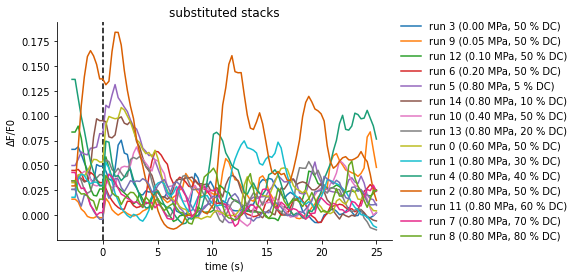

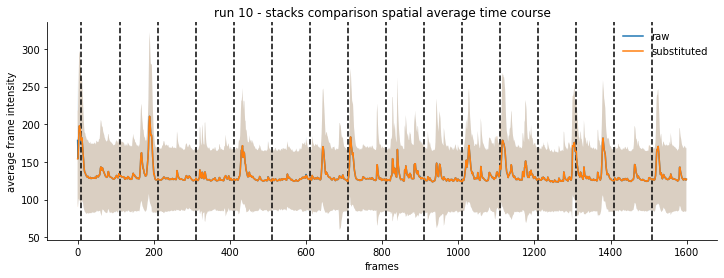

In [10]:
# Define substitutor object
submap = [
    (1, 0),
    (FrameIndex.STIM - 1, FrameIndex.STIM),
]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)

# Substitute problematic frames in every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    ss, raw_stack_fpaths, input_root, overwrite=False)

figs['trialavg_stackavg_traces substituted'] = plot_trialavg_stackavg_traces(
    substituted_stack_fpaths, ntrials_per_run, title='substituted stacks', iref=qref)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load interpolated stack for the same run
    subsituted_stack = loadtif(substituted_stack_fpaths[irun_inspect])

    # Plot comparative time course of the stacks spatial average
    figs[f'interp_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'substituted': substituted_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw and inteprolated stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        ss: substituted_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

### Denoising

The aim of this step is to remove the Speckle noise present in raw microscope aqcuisition frames. To this end, we use a modified implementation of the Kalman filter. The main parameter influencing the outcome of this processing step is the *specified filter gain* (`G`). From collective experience and comparative visual inspections, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter.

Moreover, our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.
Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`).

 04/12/2022 20:14:19: all output files already exist -> skipping
 04/12/2022 20:14:19: deriving acoustic intensity information...
 04/12/2022 20:14:23: loading data from sst_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-502.tif
 04/12/2022 20:14:23: loaded (1600, 256, 256) uint16 stack from "/gpfs/scratch/lemait01/data/usnm/filtered/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst/20190808_mouse6_region1/sst_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-502.tif"
 04/12/2022 20:14:23: initializing stack viewer
 04/12/2022 20:14:23: stack size: (1600, 256, 256)
 04/12/2022 20:14:23: computing stack intensity range across 0 - 1599 frame range...


100%|██████████| 1600/1600 [00:02<00:00, 681.57it/s]

 04/12/2022 20:14:26: intensity range: 55 - 4094



100%|██████████| 1600/1600 [00:02<00:00, 711.23it/s]

 04/12/2022 20:14:28: intensity range: 66 - 3924
 04/12/2022 20:14:28: adding 16 delimiters



100%|██████████| 1600/1600 [00:02<00:00, 582.49it/s]

 04/12/2022 20:14:33: initializing stack viewer
 04/12/2022 20:14:33: stack size: (1600, 256, 256)
 04/12/2022 20:14:33: computing stack intensity range across 0 - 1599 frame range...



100%|██████████| 1600/1600 [00:02<00:00, 732.51it/s]

 04/12/2022 20:14:36: intensity range: 55 - 4094



100%|██████████| 1600/1600 [00:02<00:00, 739.72it/s]

 04/12/2022 20:14:38: intensity range: 66 - 3924
 04/12/2022 20:14:38: rendering stack view...


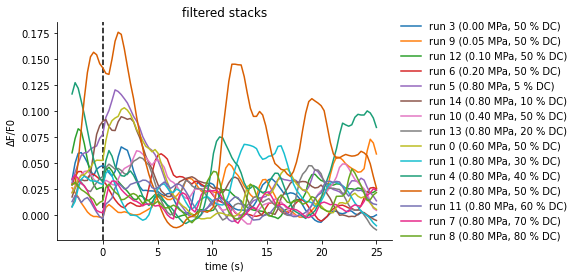

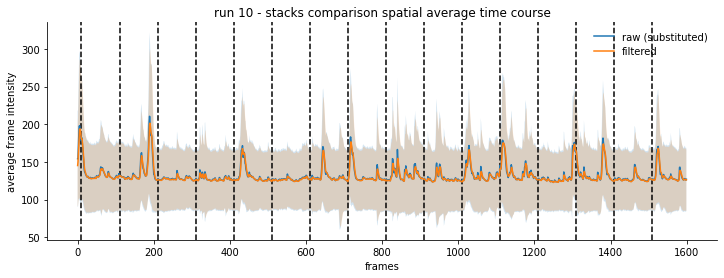

In [11]:
# Define Kalman filter
if kalman_gain is not None and kalman_gain > 0:
    kd = KalmanDenoiser(G=kalman_gain, V=0.05, npad=10)  # real filter object
else:
    kd = NoProcessor()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(ss, NoProcessor) else ss.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

figs['trialavg_stackavg_traces filtered'] = plot_trialavg_stackavg_traces(
    filtered_stack_fpaths, ntrials_per_run, title='filtered stacks', iref=qref)

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

## Functional segmentation (suite2p)

The denoised TIF stacks are fed into the *suite2p* pipeline to extract cell-specific fluorescence timeseries. This consists of several sub-steps:
- conversion from TIF to binary data "movie"
- motion correction using (rigid & non-rigid) movie registration
- movie projection at various spatial scales to compute a "correlation map"
- iterative peak detection on correlation map, and extension around these peaks to determine regions of interest (ROIs)
- extraction of associated "neuropil" areas around each ROI (contaning contaminating signals originating from axons & dendrites located outside of the plane of interest but in the acquisition volume)
- ROI classification into cell (i.e. soma) and non-cell (e.g. axons, dendrites...) ROIs based on extracted features of ROI activity (skewness, variance, correlation to surrounding pixels) and anatomy (area, aspect ratio), using a naive Bayes classifier trained on cortical data
- extraction of ROI's calcium fluorescence timecourse and optional spike deconvolution.

**Important**: if multiple stacked TIF files are provided as input, suite2p will **stack them sequentially prior to processing**. Therefore, **all stacked TIF files in the input folder must correspond to the same brain region**.

Upon completion, suite2p produces the following output files:
- `F.npy`: array of fluorescence traces (ROIs by timepoints)
- `Fneu.npy`: array of neuropil fluorescence traces (ROIs by timepoints)
- `spks.npy`: array of deconvolved traces (ROIs by timepoints)
- `stat.npy`: array of statistics computed for each cell (ROIs by 1)
- `ops.npy`: options and intermediate outputs (identical to the output of the run_s2p function)
- `iscell.npy`: specifies whether an ROI is a cell, first column is 0/1, and second column is probability that the ROI is a cell based on the default classifier
- `data.bin` (optional): registered image stack in binary format format.

These files are saved in a folder renamed after the suite2p execution parameters.

 04/12/2022 20:14:39: parsed frame rate = 3.56 fps
 04/12/2022 20:14:40: Suite2p input directory:
/gpfs/scratch/lemait01/data/usnm/filtered/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst/20190808_mouse6_region1
 04/12/2022 20:14:40: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 04/12/2022 20:14:40: suite2p code "suite2p_fs_3.56_reg_tif_tau_1.25"
 04/12/2022 20:14:40: found all suite2p output files in "/gpfs/scratch/lemait01/data/usnm/segmented/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/sst/20190808_mouse6_region1"
 04/12/2022 20:14:40: run options match 100% -> ignoring
 04/12/2022 20:14:40: empty data path -> no run
 04/12/2022 20:14:40: extracted data contains 1511 ROIs
 04/12/2022 20:14:40: zero pressure run index = 0
 04/12/2022 20:14:40: output info table corresponding to suite2p processing order:
    line  trial_length 

100%|██████████| 1600/1600 [00:02<00:00, 681.96it/s]

 04/12/2022 20:14:44: intensity range: 55 - 4094



100%|██████████| 1600/1600 [00:02<00:00, 742.79it/s]

 04/12/2022 20:14:46: intensity range: 66 - 3924
 04/12/2022 20:14:46: adding 16 delimiters



100%|██████████| 1600/1600 [00:02<00:00, 647.12it/s]

 04/12/2022 20:14:51: initializing stack viewer
 04/12/2022 20:14:51: stack size: (24000, 256, 256)
 04/12/2022 20:14:51: frame frange: [4800, 6399]
 04/12/2022 20:14:51: computing stack intensity range across 4800 - 6399 frame range...



100%|██████████| 1600/1600 [00:01<00:00, 1252.91it/s]

 04/12/2022 20:14:52: intensity range: 66.0 - 3768.0



100%|██████████| 1600/1600 [00:01<00:00, 1089.38it/s]

 04/12/2022 20:14:54: plotting suite2p registration offsets...
 04/12/2022 20:14:54: plotting suite2p registration phase correlation peaks...
 04/12/2022 20:14:54: plotting suite2p registered images...


 04/12/2022 20:14:54: plotting suite2p sparse projection maps...
 04/12/2022 20:14:55: plotting suite2p identified ROIs...
 04/12/2022 20:15:05: initializing stack viewer
 04/12/2022 20:15:05: stack size: (24000, 256, 256)
 04/12/2022 20:15:05: frame frange: [4800, 6399]
 04/12/2022 20:15:05: computing stack intensity range across 4800 - 6399 frame range...


100%|██████████| 1600/1600 [00:01<00:00, 1245.68it/s]

 04/12/2022 20:15:07: intensity range: 66.0 - 3768.0
 04/12/2022 20:15:07: rendering stack view...


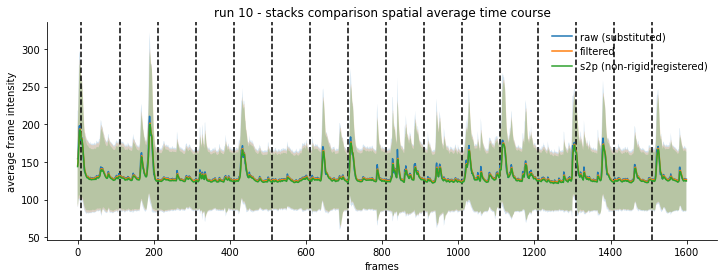

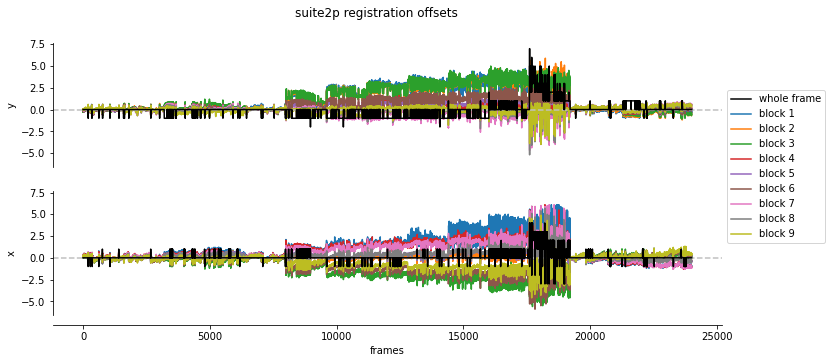

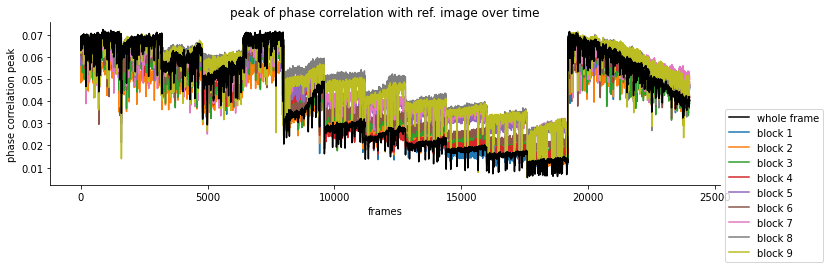

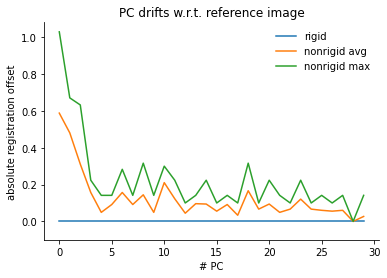

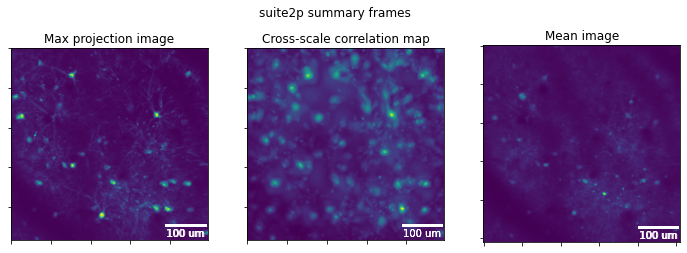

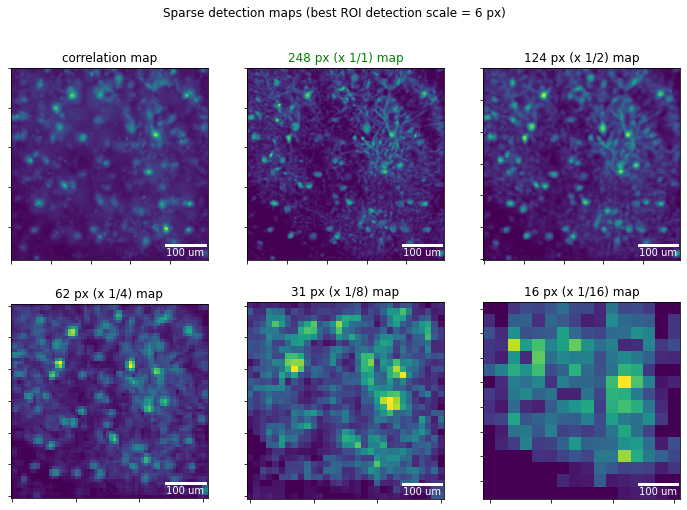

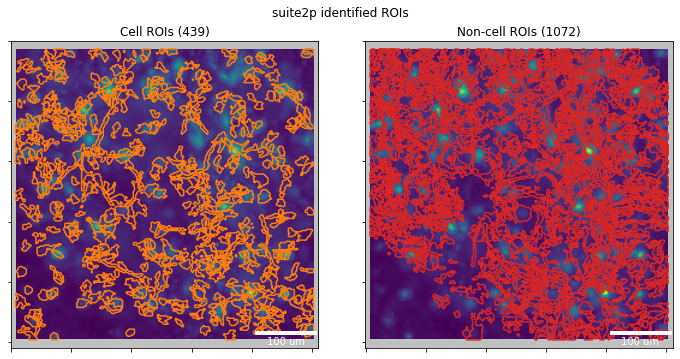

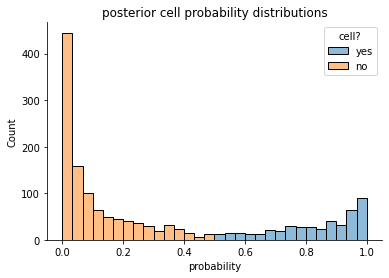

In [12]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
seg_input_key = input_root if isinstance(kd, NoProcessor) else 'filtered'
s2p_outdir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?', input_key=seg_input_key)

# Load suite2p output data and extract options dictionary
s2p_data = get_suite2p_data(s2p_outdir, withops=True, s2p_outdir=s2p_outdir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Get index of zero pressure run
try:
    irun_P0 = output_info_table[output_info_table[Label.P] == 0.].index[0]
    logger.info(f'zero pressure run index = {irun_P0}')
except IndexError as err:
    irun_P0 = None
    logger.warning('no zero-pressure run found')

# Log info table
logger.info(
    f'output info table corresponding to suite2p processing order:\n{output_info_table}')

# If run index is defined, inspect stack metrics for that particular run
irun_eq = None
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=um_per_px)

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=um_per_px)

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=um_per_px, mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing

The main aim of this step is to convert the raw fluorescence timeseries of each ROI (extracted from the suite2p output files) to normalized fluorescence timeseries. This is carried out in successive sub-steps:
- extraction of cell and associated neuropil fluorescence traces
- subtraction of neuropil background with an appropriate coeefficient (currently 0.7) to obtain a corrected fluorescence timecourse (F) of each ROI
- baseline (F0) computation and baseline correction of neuropil-corrected fluorescence traces (on a run-specific basis)
- baseline normalization to obtain relative change fluorescence traces ΔF/F0 (also run-specific)
- noise level and variation range estimation and subsequent noise-normalization of relative change fluorescence traces into z-score traces.

Upon completion, a post-processed file is created named after the dataset (date, mouse, region) ID, in which the following outputs are saved:
- `info_table`: summary table of the parameters pertaining to each run
- `ROI_masks`: table of the pixel masks of each selected ROI in the reference frame.
- `timeseries`: dff and z-score timeseries (along with their ROI, run, trial and frame index information)

### Load processed data if available

In [13]:
s2p_outbase, s2p_basedir = os.path.split(s2p_outdir)
postpro_dir = get_output_equivalent(
    s2p_outbase, 'segmented', f'post-processed/{postpro_id}')
postpro_fpath = os.path.join(postpro_dir, f'{s2p_basedir}.h5')
try:
    logger.info('loading data...')
    xtimeseries, output_info_table, ROI_masks = load_postpro_dataset(postpro_fpath)
    is_postpro_data_available = True
    logger.info(f'experiment info table:\n{output_info_table}')
    logger.info(f'post-processed timeseries: {describe_dataframe_index(xtimeseries)} dataframe')
    logger.info(f'ROI masks: {describe_dataframe_index(ROI_masks)} dataframe')
except FileNotFoundError as err:
    logger.warning(err)
    is_postpro_data_available = False

 04/12/2022 20:15:11: loading data...
 04/12/2022 20:15:12: loading experiment info table...
 04/12/2022 20:15:12: loading processed timeseries data...
 04/12/2022 20:15:14: loading ROI masks...
 04/12/2022 20:15:14: data successfully loaded
 04/12/2022 20:15:14: experiment info table:
    line  trial_length  PRF (Hz)  duration (s)   fps  P (MPa)  DC (%)  run ID  \
run                                                                             
0    sst           100     100.0           0.2  3.56     0.00    50.0     506   
1    sst           100     100.0           0.2  3.56     0.10    50.0     504   
2    sst           100     100.0           0.2  3.56     0.20    50.0     503   
3    sst           100     100.0           0.2  3.56     0.40    50.0     502   
4    sst           100     100.0           0.2  3.56     0.05    50.0     505   
5    sst           100     100.0           0.2  3.56     0.60    50.0     501   
6    sst           100     100.0           0.2  3.56     0.80    

### Get fluorescence timeseries data

In [14]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
raw_timeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(raw_timeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
raw_timeseries = separate_runs(raw_timeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
raw_timeseries = separate_trials(raw_timeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Add time to table
raw_timeseries[Label.FPS] = fps
raw_timeseries = add_time_to_table(raw_timeseries)

# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
raw_timeseries = raw_timeseries.loc[(icells), :]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI
    # and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index), :]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=um_per_px, superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = raw_timeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)

# Identify invalid ROIs with zero F_ROI range 
logger.info('identifying outliers with zero fluorescence traces...')
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
raw_timeseries = raw_timeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Create dataframe to store stats on valid ROIs
ROIstats = pd.DataFrame(index=raw_timeseries.index.unique(Label.ROI))

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=um_per_px, superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_ROI_traces(raw_timeseries, Label.F_ROI)

# Plot aggregate traces (both ROI - neuropil comparison and ROI across runs)
figs[f'{Label.F_ROI} aggregate traces comp'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F_ROI, Label.F_NEU], icorrect=qref)
figs[f'{Label.F_ROI} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.F_ROI, hue=Label.RUN, icorrect=qref)

# Compute and plot skewness of ROI and associated neuropil traces
skewnesses = raw_timeseries[[Label.F_ROI, Label.F_NEU]].groupby(Label.ROI).agg(skew)
ROIstats = pd.concat([ROIstats, skewnesses.add_suffix(' skewness')], axis=1)
jg = sns.jointplot(
    data=ROIstats, x=f'{Label.F_ROI} skewness', y=f'{Label.F_NEU} skewness', height=4)
harmonize_jointplot_limits(jg)
add_jointplot_line(jg, 0.)
jg.ax_joint.axline((0, 0), (1, 1), ls='--', color='k')
figs['ROI vs NEU skewnesses'] = jg.figure

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = raw_timeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    skewvals = np.linspace(*bounds(ROIstats[f'{Label.F_ROI} skewness']), nROIs_inspect)
    iROI_inspect = np.array([np.abs(ROIstats[f'{Label.F_ROI} skewness'] - s).idxmin() for s in skewvals])
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_multivar_traces(
        raw_timeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

In [15]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients minimizing specific cost function
costfunc = force_positive_Fc(center_around(neuropil_scaling_coeff))
alpha_bounds = (-.2, 2)
optfunc = lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds)
logger.info(f'computing neuropil coefficients minimizing {costfunc.__name__} function '
            f'within {alpha_bounds} interval...')
groups = raw_timeseries.groupby(Label.ROI)
with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
    alphas = groups.apply(pbar_update(optfunc, pbar)).rename(Label.ALPHA)

# Plot resulting distribution of neuropil subtraction coefficients
figs['neuropil coeffs'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('optimal neuropil scaling coefficients across ROIs')
sns.violinplot(data=alphas.to_frame(), y=Label.ALPHA, ax=ax)
ax.set_ylim(*alpha_bounds)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
raw_timeseries[Label.F] = raw_timeseries[Label.F_ROI] - alphas * raw_timeseries[Label.F_NEU]

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_ROI_traces(raw_timeseries, Label.F)

# Plot aggregate traces
figs[f'{Label.F} aggregate traces comp'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F, Label.F_ROI, Label.F_NEU], icorrect=qref)
figs[f'{Label.F} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.F, hue=Label.RUN, icorrect=qref)

# Compute skewness of corrected fluoresence traces and plot against that of original traces
ROIstats[f'{Label.F} skewness'] = raw_timeseries[Label.F].groupby(Label.ROI).agg(skew)
jg = sns.jointplot(
    data=ROIstats, x=f'{Label.F_ROI} skewness', y=f'{Label.F} skewness', height=4)
harmonize_jointplot_limits(jg)
add_jointplot_line(jg, 0.)
jg.ax_joint.axline((0, 0), (1, 1), ls='--', color='k')
figs['ROI vs corrected skewnesses'] = jg.figure

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    title = [f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt]
    figs['F_trace'] = plot_multivar_traces(
        raw_timeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters, title=title)
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1],
                       color='silver', alpha=0.5)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a percentile sliding window and (2) a gaussian filter, over the entire fluorescence timecourse. 

<span style="color:orange">This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).</span>

Extracted baselines are then used to correct fluorescence signals from slow drifts, by subtraction of the mean-corrected time-varying baseline.

In [16]:
%%skip $is_postpro_data_available

# Map skewness to baseline extraction quantile
ROIstats['quantile'] = skew_to_quantile(ROIstats[f'{Label.F} skewness'])
jg = sns.jointplot(data=ROIstats, x=f'{Label.F} skewness', y='quantile', height=4, ylim=(0, 1))
add_jointplot_line(jg, 0., mode='x')
add_jointplot_line(jg, 0.5, mode='y')
figs['skew - quantile map'] = jg.figure

# Quantile-based function
bfunc = get_quantile_baseline_func(
    fps, wquantile=baseline_wquantile, q=baseline_quantile, wsmooth=baseline_wsmoothing)

#  Compute baseline for each ROI
logger.info('computing baseline for each ROI')
groups = raw_timeseries[Label.F].groupby(Label.ROI)
with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
    raw_timeseries[Label.F0] = groups.transform(pbar_update(bfunc, pbar))

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters, title=baseline_id)

# Apply mean correction to remaining fluorescence and baseline signals
logger.info('subtracting mean-corrected baseline from signals for each ROI & run...')
F0_mean = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
F0_mean_exp = expand_to_match(F0_mean, raw_timeseries.index)
# Apply baseline corretor to both fluorescence and baseline signals
detrender = raw_timeseries[Label.F0] - F0_mean_exp
raw_timeseries[Label.F_DETRENDED] = raw_timeseries[Label.F] - detrender
raw_timeseries[Label.F0_DETRENDED] = raw_timeseries[Label.F0] - detrender

# Plot detrended fluorescence for all ROIs
figs['Ftraces_allROIs_detrended'] = plot_ROI_traces(raw_timeseries, Label.F_DETRENDED)

# Plot aggregate traces
figs[f'{Label.F_DETRENDED} aggregate traces comp'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F, Label.F_DETRENDED], icorrect=qref)
figs[f'{Label.F_DETRENDED} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.F_DETRENDED, hue=Label.RUN, icorrect=qref)

### ΔF/F0 computation

In [17]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing dFF...')
raw_timeseries[Label.DFF] = (
    raw_timeseries[Label.F_DETRENDED] - raw_timeseries[Label.F0_DETRENDED]) / raw_timeseries[Label.F0_DETRENDED]

# # Subtract pre-stimulus run average from dFF traces
# logger.info('subtracting pre-stimulus run average from dFF traces...')
# dFF_prestim_mean = raw_timeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.DFF].groupby(
#     [Label.ROI, Label.RUN]).mean()
# raw_timeseries[Label.DFF] -= expand_to_match(dFF_prestim_mean, raw_timeseries.index)

# Plot aggregate traces
figs[f'{Label.DFF} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.DFF, hue=Label.RUN)

# Plot DFF for all ROIs
nROIs = len(raw_timeseries.index.unique(level=Label.ROI))
figs['DFFtraces_allROIs'] = plot_ROI_traces(
    raw_timeseries, Label.DFF, ydelimiters=np.zeros(nROIs), stacked=True, ntraces=20)

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'dFF_trace_run{irun_inspect}'].axes:
        ax.axhline(0., c='k', ls='--');

### Detrend DFF traces

In [18]:
# # Interpolate DFF traces
# # nanchors_per_trial = 2
# # ianchors = np.round(np.linspace(
# #     0, NFRAMES_PER_TRIAL, nanchors_per_trial + 1)).astype(int)[:-1] + FrameIndex.STIM
# ianchors = None
# logger.info(
#     f'interpolating {Label.DFF} traces with cubic splines...')
# groups = raw_timeseries[Label.DFF].groupby([Label.ROI, Label.RUN])
# with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
#     raw_timeseries[f'interp {Label.DFF}'] = groups.transform(
#         pbar_update(lambda s: spline_interp_run(s, ianchors=ianchors), pbar))

# # Plot consecutive trials of DFF and interpolated DFF of selected ROI for selected run
# if nROIs_inspect > 0 and irun_eq is not None:
#     fig = plot_multivar_traces(
#         raw_timeseries[[Label.DFF, f'interp {Label.DFF}']],
#         iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
#     for ax in fig.axes:
#         ax.axhline(0., c='k', ls='--');

# # Compute and plot detrended DFF
# raw_timeseries[f'detrended {Label.DFF}'] = raw_timeseries[Label.DFF] - raw_timeseries[f'interp {Label.DFF}']
# logger.info('plotting aggregate traces per run')
# fig = plot_aggregate_traces(raw_timeseries, fps, f'detrended {Label.DFF}', hue=Label.RUN)

### Z(ΔF/F0) computation

In [19]:
%%skip $is_postpro_data_available

# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
groups = raw_timeseries[Label.DFF].groupby(Label.ROI)
with tqdm(total=groups.ngroups, position=0, leave=True) as pbar:
    dFF_histfits = groups.agg(pbar_update(nan_proof(gauss_histogram_fit), pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot distributions of the relevant extracted Gaussian parameters
figs['gaussianfits_dists'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('dFF Gaussian fit noise distributions')
sns.scatterplot(data=dFF_histparams, x='x0', y='sigma', ax=ax)

# # Compute dFF standard deviation in baseline intervals
# logger.info('estimating dFF noise level inside baseline intervals...')
# dFF_noise = raw_timeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.BASELINE], Label.DFF].groupby(
#     [Label.ROI, Label.RUN]).std()

# Normalize dFF traces by baseline noise level to obtain dFF z-scores
logger.info('normalizing DFF by baseline noise level to obtain z-scores...')
dFF_params_exp = expand_to_match(dFF_histparams, raw_timeseries.index)
raw_timeseries[Label.ZSCORE] = (
    (raw_timeseries.loc[:, Label.DFF] - dFF_params_exp['x0']) / dFF_params_exp['sigma'])
# raw_timeseries[Label.ZSCORE] = raw_timeseries.loc[:, Label.DFF] / expand_to_match(dFF_noise, raw_timeseries.index)

# Plot aggregate traces
figs[f'{Label.ZSCORE} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.ZSCORE, hue=Label.RUN)
# # Plot shaded area over baseline estimation interval
# tvec = raw_timeseries[Label.TIME].unique()
# baseline_span = bounds(tvec[FrameIndex.BASELINE])
# figs[f'{Label.ZSCORE} aggregate traces'].axes[0].axvspan(
#     *baseline_span, fc='silver', ec=None, alpha=.5)

# Plot z-scores for all ROIs with markers at +/- detection threshold
zthr = pvalue_to_zscore(PTHR_DETECTION)
ydelims = np.tile(np.array([-1, 1]) * zthr, (nROIs, 1))
figs['DFFtraces_allROIs'] = plot_ROI_traces(
    raw_timeseries, Label.ZSCORE, ydelimiters=ydelims, stacked=True, ntraces=20)

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_multivar_traces(
        raw_timeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(-zthr, zthr, fc='silver', ec=None, alpha=0.5);

### Reduce timeseries data to dff and z-scores only

In [20]:
%%skip $is_postpro_data_available
logger.info('reducing timeseries to dFF nd z-scores only...')
xtimeseries = raw_timeseries.loc[:, [Label.DFF, Label.ZSCORE]].copy()

### Save ΔF/F and Z(ΔF/F) traces

In [21]:
%%skip $is_postpro_data_available
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], xtimeseries.index.unique(level=Label.ROI))

# Save data in output directory
save_postpro_dataset(postpro_fpath, xtimeseries, output_info_table, ROI_masks)

### Visualize ΔF/F traces per run (and heatmap over trial for specific run)

 04/12/2022 20:15:24: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:15:24: adding time info to table...
 04/12/2022 20:15:25: adding time info to table...
 04/12/2022 20:15:25: plotting ΔF/F0 trial heatmaps...


16it [00:07,  2.04it/s]                        


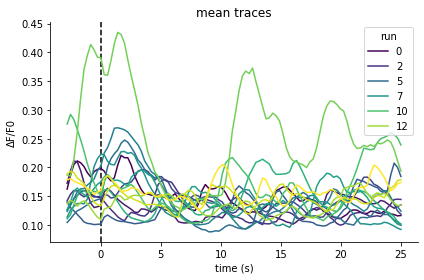

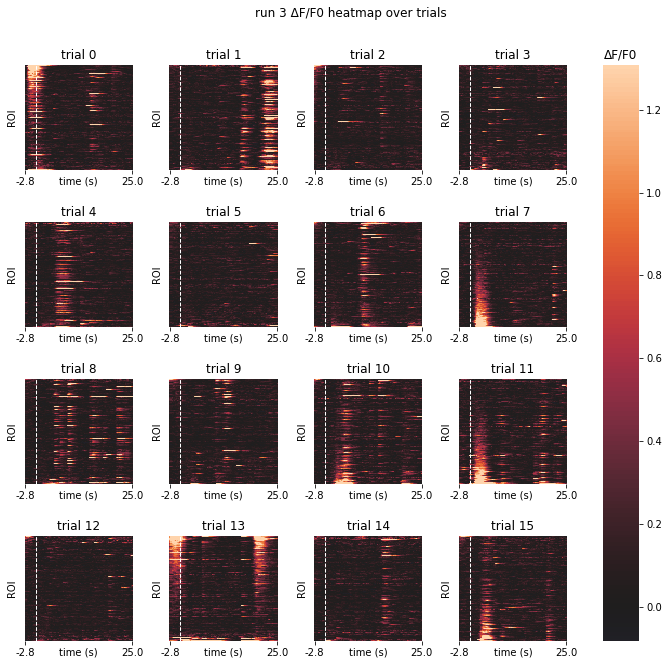

In [22]:
figs[f'{Label.DFF} aggregate traces'] = plot_aggregate_traces(
    xtimeseries, fps, Label.DFF, hue=Label.RUN)
if irun_eq is not None:
    figs[f'run {irun_eq} {Label.DFF} heatmap over trials'] = plot_trial_heatmap(
        xtimeseries, Label.DFF, fps, irun=irun_eq, col=Label.TRIAL, 
        sort_rows=True, rasterized=True)
    figs[f'run {irun_eq} {Label.DFF} heatmap over trials'].suptitle(
        f'run {irun_eq} {Label.DFF} heatmap over trials')

## Statistics (response metrics & cell classification)

The objective of this step is to extract response metrics and their parameter dependency for each cell, and to assign a "responder class" to each cell. 
This analysis consists of the following sub-steps:
- quantification of lateral motion over time (using the registration offsets timeseries outputed by suite2p), detection of motion artifacts, and exclusion of associated trials
- exclusion of trials containing outlier data points
- events detection and quantification of event rates over trial intervals
- exclusion of trials with abnormal pre-stimulus fluorescence levels
- averaging of traces across valid trials for each ROI & run
- heatmaps of activity metrics (ΔF/F0 and event rate) of the entire population across conditions
- quantification and statistical characterization of stimulus-evoked change in activity metrics (ΔF/F0 and event rate), and classification of responses per ROI and condition
- classification of cells by responder type based on their response distributions across conditions

Upon completion, a trial-averaged file is created named after the dataset (date, mouse, region) ID, in which the following outputs are saved:
- `timeseries`: dff, z-score and event rate trial-averaged timeseries (along with their ROI, run and frame index information)
- `stats`: trial-averaged statistics dataframe
- `ROI_masks`: table of the pixel masks of each selected ROI in the reference frame.

### Create statistics dataframe

<span style="color:orange">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

 04/12/2022 20:15:36: creating statistics dataframe
 04/12/2022 20:15:36: deriving acoustic intensity information...
 04/12/2022 20:15:36: adding experimental info to stats...
 04/12/2022 20:15:36: adding "discarded" labels...
 04/12/2022 20:15:36: stats table:


/gpfs/data/shohamlab/theo/code/usnm2p/plotters.py:2759: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


line  trial_length  PRF (Hz)  duration (s)   fps  P (MPa)  \
ROI  run trial                                                             
0    0   0      sst           100     100.0           0.2  3.56      0.0   
         1      sst           100     100.0           0.2  3.56      0.0   
         2      sst           100     100.0           0.2  3.56      0.0   
         3      sst           100     100.0           0.2  3.56      0.0   
         4      sst           100     100.0           0.2  3.56      0.0   
...             ...           ...       ...           ...   ...      ...   
1503 14  11     sst           100     100.0           0.2  3.56      0.8   
         12     sst           100     100.0           0.2  3.56      0.8   
         13     sst           100     100.0           0.2  3.56      0.8   
         14     sst           100     100.0           0.2  3.56      0.8   
         15     sst           100     100.0           0.2  3.56      0.8   

                DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  
ROI  run trial                                                             
0    0   0        50.0     506        0.000000         0.00000       True  
         1        50.0     506        0.000000         0.00000      False  
         2        50.0     506        0.000000         0.00000      False  
         3        50.0     506        0.000000         0.00000      False  
         4        50.0     506        0.000000         0.00000      False  
...                ...     ...             ...             ...        ...  
1503 14  11       80.0     509       19.784475        15.82758      False  
         12       80.0     509       19.784475        15.82758      False  
         13       80.0     509       19.784475        15.82758      False  
         14       80.0     509       19.784475        15.82758      False  
         15       80.0     509       19.784475        15.82758      False  

[102240 rows x 11 columns]

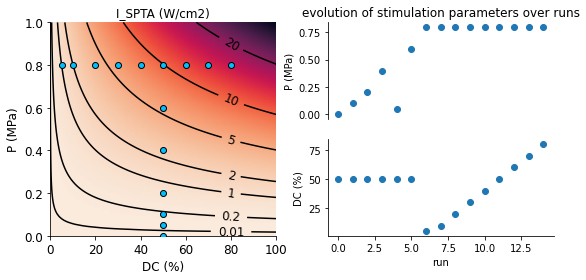

In [23]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: xtimeseries.index.unique(k) for k in xtimeseries.index.names}

# Create stats dataframes
logger.info('creating statistics dataframe')
stats = pd.DataFrame()

# Add information about pulse and time-average acoustic intensity to info table
output_info_table = add_intensity_to_table(output_info_table)

# Add experimental info to stats
if Label.P not in stats:
    logger.info('adding experimental info to stats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels(
        [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    stats = pd.concat([exp_output_table, stats], axis=1) 

# Add info about discarded trials
logger.info('adding "discarded" labels...')
stats[Label.DISCARDED] = False
stats.loc[pd.IndexSlice[:, :, ITRIALS_DISCARD], Label.DISCARDED] = True

# Visualize run order (as processed by suite2p)
figs['protocol_summary'] = plot_protocol(output_info_table, xkey=Label.RUN)

logger.info('stats table:')
stats

### Identify & reject trials with significant stimulus-evoked motion artefact

 04/12/2022 20:16:55: computing diplacement velocity over time from registration offsets...
 04/12/2022 20:16:55: correcting displacement velocity at indices [1, 10] to compensate for frames substitution...
 04/12/2022 20:16:59: identified 15 / 240 trials (6.2%) with abnormal peak or average displacement velocities
 04/12/2022 20:16:59: identifying samples without [discarded, motion] tags
 04/12/2022 20:16:59: identifying conditions with >= 5 valid trials
 04/12/2022 20:16:59: adding expanded validity index to timeseries ...
 04/12/2022 20:17:03: filtering timeseries ...
 04/12/2022 20:17:12: grouping data by ['motion', 'frame'] and averaging...
 04/12/2022 20:17:13: adding time info to table...
 04/12/2022 20:17:14: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:17:15: adding time info to table...


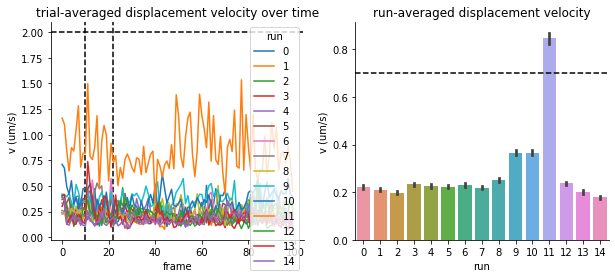

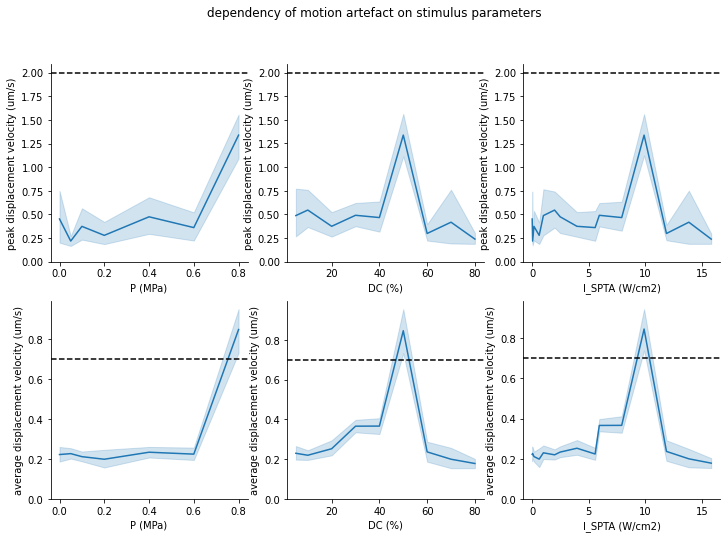

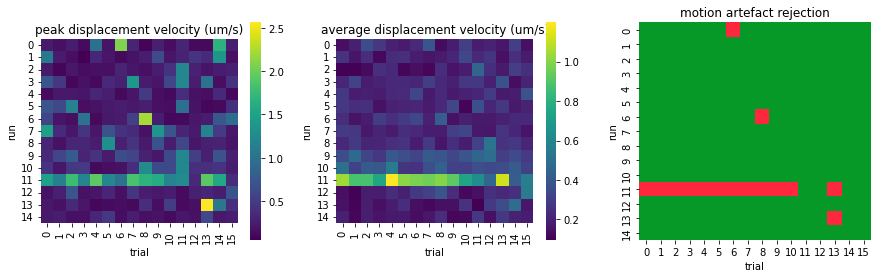

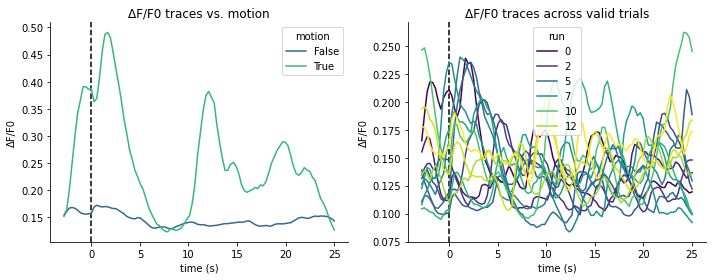

In [25]:
from constants import VDISP_PEAK_THR, VDISP_AVG_THR

# Create (run, trial, frame) multi-index
exp_mux_keys = [Label.RUN, Label.TRIAL, Label.FRAME]
exp_mux = pd.MultiIndex.from_product(
    [index_dims[k] for k in exp_mux_keys], names=exp_mux_keys)

# Compute displacement velocity profiles
if isinstance(ss, StackSubstitutor):
    isubs = [max(x) for x in ss.submap if abs(x[0] - x[1]) == 1]
else:
    isubs = None
vdisp = compute_displacement_velocity(s2p_ops, exp_mux, um_per_px, fps, isubs=isubs)

# Plot average displacement velocity profile for each run
figs['vdisp_profiles'], axes = plt.subplots(1, 2, figsize=(10, 4))
for ax in axes:
    sns.despine(ax=ax)
ax = axes[0]
ax.set_title('trial-averaged displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    hue=Label.RUN, ci=None, palette='tab10')
ax.axhline(VDISP_PEAK_THR, ls='--', c='k')
ax = axes[1]
ax.set_title('run-averaged displacement velocity')
sns.barplot(
    data=vdisp.to_frame().reset_index(Label.RUN), 
    x=Label.RUN, y=vdisp.name, ax=ax, ci=CI)
ax.axhline(VDISP_AVG_THR, ls='--', c='k')

# Compute peak of displacement velocity within response window for each run and trial
# and assess if motion exceeded threshold
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_metrics = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(
    find_response_peak).rename(Label.PEAK_DISP_VEL).to_frame()
vdisp_metrics[Label.MOTION] = vdisp_metrics[Label.PEAK_DISP_VEL] > VDISP_PEAK_THR

# Compute average of displacement velocity across trial interval for each run and trial
# and assess if motion exceeded threshold
vdisp_metrics[Label.AVG_DISP_VEL] = vdisp.groupby([Label.RUN, Label.TRIAL]).mean()
vdisp_metrics[Label.MOTION] = np.logical_or(
    vdisp_metrics[Label.MOTION],
    vdisp_metrics[Label.AVG_DISP_VEL] > VDISP_AVG_THR)

nmotion = vdisp_metrics[Label.MOTION].sum()
ntot = len(vdisp_metrics)

# Add displacement velocity metrics and motion status info to stats
exp_vdisp_metrics = repeat_along_new_dim(
    vdisp_metrics, Label.ROI, stats.index.unique(Label.ROI)
    ).swaplevel(0, 2).swaplevel(1, 2).sort_index()
for k in exp_vdisp_metrics:
    stats[k] = exp_vdisp_metrics[k]

# Add stimulus parameters info to vdisp metrics dataframe
vdisp_metrics = pd.concat([vdisp_metrics, repeat_along_new_dim(
    output_info_table[[Label.P, Label.DC, Label.ISPTA]],
    Label.TRIAL, exp_mux.unique(level=Label.TRIAL))], axis=1)

# Plot dependency of motion artefact on pressure & duty cycle 
figs['vdispmetrics_vs_stimparams'], axes = plt.subplots(2, 3, figsize=(12, 8))
figs['vdispmetrics_vs_stimparams'].suptitle('dependency of motion artefact on stimulus parameters')
for axrow, ykey, vcrit in zip(axes, [Label.PEAK_DISP_VEL, Label.AVG_DISP_VEL], [VDISP_PEAK_THR, VDISP_AVG_THR]):
    for ax, xkey in zip(axrow, [Label.P, Label.DC]):
        sns.lineplot(
            data=get_xdep_data(vdisp_metrics, xkey), x=xkey, y=ykey, ax=ax)
    sns.lineplot(data=vdisp_metrics, x=Label.ISPTA, y=ykey, ax=axrow[-1])
    for ax in axrow:
        sns.despine(ax=ax)
        ax.axhline(vcrit, ls='--', c='k')
        ax.set_ylim(0, ax.get_ylim()[1])

# Plot peak and average displacement velocities and motion artefact rejection heatmaps
figs['vdispmetrics_motionreject_maps'], axes = plt.subplots(1, 3, figsize=(15, 4))
for ax in axes:
    ax.set_aspect(1.)
ax = axes[0]
ax.set_title(Label.PEAK_DISP_VEL)
sns.heatmap(vdisp_metrics[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)
ax = axes[1]
ax.set_title(Label.AVG_DISP_VEL)
sns.heatmap(vdisp_metrics[Label.AVG_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)
ax = axes[2]
ax.set_title('motion artefact rejection')
sns.heatmap(vdisp_metrics[Label.MOTION].unstack(), ax=ax, cmap=rdgn, cbar=False)

# Log identified motion trials
logger.info(
    f'identified {nmotion} / {ntot} trials ({nmotion / ntot * 1e2:.1f}%)'
    f' with abnormal peak or average displacement velocities')

# Compute new valid timeseries
vtimeseries = valid_timeseries(xtimeseries, stats)

# Plot DFF traces for both categories, and valid across runs
figs[f'{Label.DFF} motion filtering'], axes = plt.subplots(1, 2, figsize=(10, 4))
plot_aggregate_traces(
    expand_and_add(stats[Label.MOTION].to_frame(), xtimeseries.copy()),
    fps, Label.DFF, hue=Label.MOTION, ax=axes[0])
axes[0].set_title(f'{Label.DFF} traces vs. motion')
plot_aggregate_traces(vtimeseries, fps, Label.DFF, hue=Label.RUN, ax=axes[1])
axes[1].set_title(f'{Label.DFF} traces across valid trials');

### Identify & reject trials with outlier data points

 04/12/2022 20:17:34: identifying trials with ΔF/F0 data points outside (-3.2913, 3.4617) interval...
 04/12/2022 20:17:52: identified 2618 / 102240 (2.56%) trials with outlier data points
 04/12/2022 20:17:53: identifying samples without [discarded, motion, outlier] tags
 04/12/2022 20:17:53: identifying conditions with >= 5 valid trials
 04/12/2022 20:17:53: adding expanded validity index to timeseries ...
 04/12/2022 20:17:58: filtering timeseries ...
 04/12/2022 20:18:06: grouping data by ['outlier', 'frame'] and averaging...
 04/12/2022 20:18:07: adding time info to table...
 04/12/2022 20:18:08: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:18:09: adding time info to table...


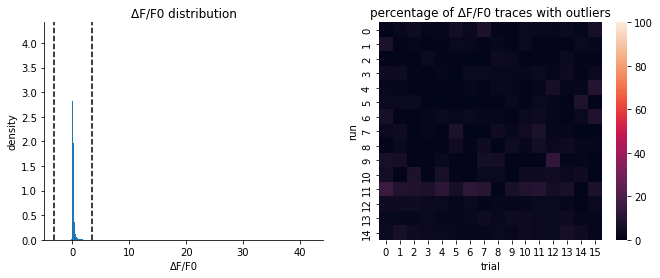

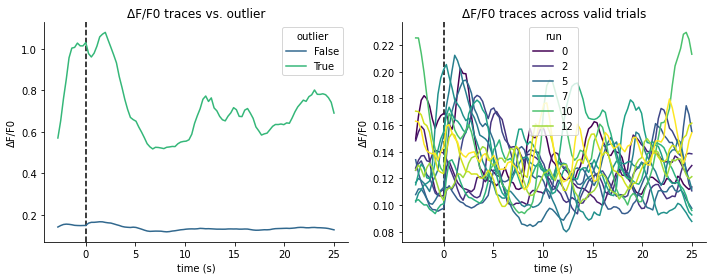

In [26]:
# Estimate interval of resonable data values
from constants import NSTD_DEV_THR
ymed, ystd = xtimeseries[Label.DFF].median(), xtimeseries[Label.DFF].std()
ystd = xtimeseries[Label.DFF].std()
ybounds = (ymed - NSTD_DEV_THR * ystd, ymed + NSTD_DEV_THR * ystd)

# Identify trials with data points outside of this range
logger.info(
    f'identifying trials with {Label.DFF} data points outside '
    f'({ybounds[0]:.4f}, {ybounds[1]:.4f}) interval...')
stats[Label.OUTLIER] = xtimeseries[Label.DFF].groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).apply(lambda s: not is_bounded(s, *ybounds))
pct_outlier = stats[Label.OUTLIER].sum() / len(stats) * 100
logger.info(
    f'identified {stats[Label.OUTLIER].sum()} / {len(stats)} ({pct_outlier:.2f}%) trials '
    'with outlier data points')

# Plot histogram distribution with identified outliers, 
# and percentage of outlier traces per run & trial
figs[f'{Label.DFF} distribution & outliers'], axes = plt.subplots(1, 2, figsize=(11, 4))
for ax in axes:
    sns.despine(ax=ax)
ax = axes[0]
ax.set_title(f'{Label.DFF} distribution')
ax.set_xlabel(Label.DFF)
ax.set_ylabel('density')
ax.hist(xtimeseries[Label.DFF], bins=500, density=True)
for y in ybounds:
    ax.axvline(y, c='k', ls='--')
nROIs = len(stats.index.unique(Label.ROI))
noutliers_per_cond_trial = stats[Label.OUTLIER].groupby([Label.RUN, Label.TRIAL]).sum()
pct_outliers_per_cond_trial = noutliers_per_cond_trial / nROIs * 100
ax = axes[1]
ax.set_title(f'percentage of {Label.DFF} traces with outliers')
sns.heatmap(pct_outliers_per_cond_trial.unstack(), ax=ax, vmin=0, vmax=100)

# Compute new valid timeseries
vtimeseries = valid_timeseries(xtimeseries, stats)

# Plot DFF traces for both categories, and valid across runs
figs[f'{Label.DFF} outlier filtering'], axes = plt.subplots(1, 2, figsize=(10, 4))
plot_aggregate_traces(
    expand_and_add(stats[Label.OUTLIER].to_frame(), xtimeseries.copy()),
    fps, Label.DFF, hue=Label.OUTLIER, ax=axes[0])
axes[0].set_title(f'{Label.DFF} traces vs. outlier')
plot_aggregate_traces(vtimeseries, fps, Label.DFF, hue=Label.RUN, ax=axes[1])
axes[1].set_title(f'{Label.DFF} traces across valid trials');

### Detect activity over valid trials and compute event rate

 04/12/2022 20:18:11: detecting activity events in Z(ΔF/F0) signals: 
    - min distance = 7 indexes
    - min Z(ΔF/F0) height = 1.64
 04/12/2022 20:18:13: grouping events over trials
 04/12/2022 20:18:15: counting events for each frame index...
 04/12/2022 20:18:16: multiplying by frame rate and normalizing by # trials per run to get event rate...
 04/12/2022 20:18:20: smoothing event rates with 5 frames (1.40 s) moving average...
 04/12/2022 20:18:24: adding time info to table...
 04/12/2022 20:18:24: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:18:24: adding time info to table...


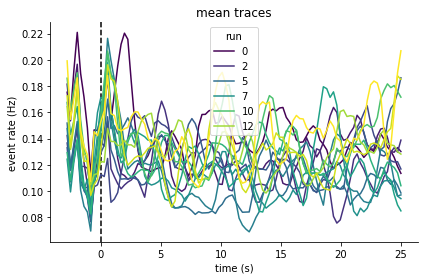

In [27]:
# Detect activity events on z-scored signals
from constants import MIN_EVENTS_DISTANCE
idistance = int(np.round(MIN_EVENTS_DISTANCE * fps))  # minimum distance between peaks (indexes)
height = pvalue_to_zscore(PTHR_DETECTION)  # minimum peak height
evts_params = [
    f'min distance = {idistance} indexes',
    f'min {Label.ZSCORE} height = {height:.2f}']
peaksstr = '\n'.join(f'    - {x}' for x in evts_params)
logger.info(f'detecting activity events in {Label.ZSCORE} signals: \n{peaksstr}')
idx_events = vtimeseries[Label.ZSCORE].groupby([Label.ROI, Label.RUN]).apply(
    lambda s: find_peaks(s.values, height=height, distance=idistance)[0]).rename('event idxs')

# Aggregate event indexes over trials
logger.info('grouping events over trials')
idx_events_agg = idx_events.groupby([Label.ROI, Label.RUN]).apply(
    lambda x: np.mod(x, NFRAMES_PER_TRIAL))

# Count number of events for each frame index
logger.info('counting events for each frame index...')
bins = np.arange(0, NFRAMES_PER_TRIAL + 0.5) - 0.5
nevents = idx_events_agg.apply(
    lambda s: np.histogram(s, bins)[0]).rename('# events').explode()
midpts = (bins[:-1] + bins[1:]) / 2
nreps = nevents.index.nunique()
exp_midpts = np.tile(midpts, (nreps, 1)).ravel()
nevents = nevents.to_frame()
nevents[Label.FRAME] = exp_midpts.astype(int)
nevents.set_index(Label.FRAME, append=True, inplace=True)
nevents = nevents['# events']

# Multiply by frame rate and normalize by number of trials to get event rate
logger.info(
    'multiplying by frame rate and normalizing by # trials per run to get event rate...')
trial_count = vtimeseries[Label.DFF].groupby(
    [Label.ROI, Label.RUN, Label.TRIAL]).first().groupby([Label.ROI, Label.RUN]).count()
event_rates = (nevents * fps / trial_count).rename(Label.EVENT_RATE)

# Apply moving average to smooth event rate profiles
from constants import EVENTS_BIN_INTERVAL
if EVENTS_BIN_INTERVAL is not None:
    wlen = int(np.round(EVENTS_BIN_INTERVAL * fps))
    if wlen % 2 == 0:
        wlen += 1
    wtime = wlen / fps
    logger.info(f'smoothing event rates with {wlen} frames ({wtime:.2f} s) moving average...')
    event_rates = event_rates.groupby([Label.ROI, Label.RUN]).transform(
        lambda s: apply_rolling_window(s.values, wlen))

# Visualize event rate traces per run
figs[f'{Label.EVENT_RATE} aggregate traces valid'] = plot_aggregate_traces(
    add_time_to_table(event_rates.to_frame(), fps=fps), 
    fps, Label.EVENT_RATE, hue=Label.RUN)

### Identify & reject trials with pre-stimulus activity and/or "inhibition"

 04/12/2022 20:18:25: analyzing Z(ΔF/F0) relative pre-stimulus levels...
 04/12/2022 20:18:26: setting pre-stimulus Z(ΔF/F0) absolute outlier threshold to 5.455
 04/12/2022 20:18:26: identified:
   - 5787/102240 trials (5.66%) significant pre-stimulus activity
   - 5/102240 trials (0.00%) significant pre-stimulus inhibition
   - 5792/102240 trials (5.67%) pre-stimulus outlier data
 04/12/2022 20:18:27: identified 1/240 trials (0.4%) with more than 50.0 % pre-active cells
 04/12/2022 20:18:27: identifying samples without [discarded, motion, outlier, pre-stim cell activity?, pre-stim population activity?, pre-stim cell inhibition?] tags
 04/12/2022 20:18:27: identifying conditions with >= 5 valid trials
 04/12/2022 20:18:27: adding expanded validity index to timeseries ...
 04/12/2022 20:18:32: filtering timeseries ...
 04/12/2022 20:18:40: grouping data by ['pre-stimulus outlier?', 'frame'] and averaging...
 04/12/2022 20:18:41: adding time info to table...
 04/12/2022 20:18:42: groupin

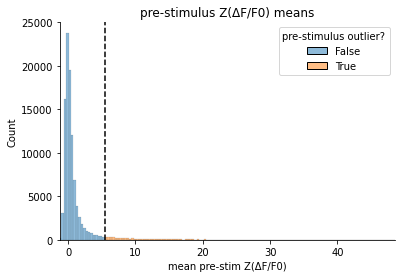

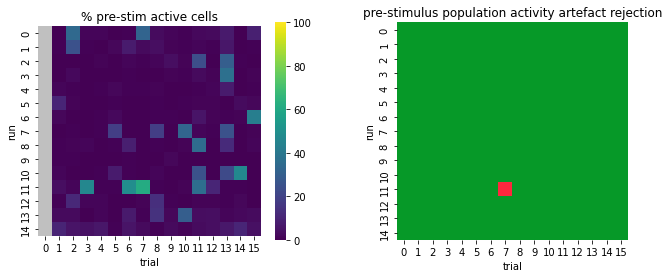

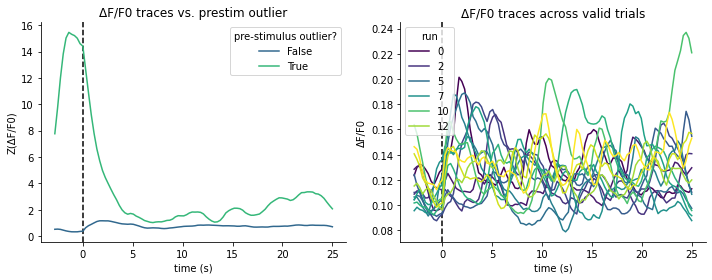

In [28]:
# Compute mean z-score in pre-stimulus window for each trial
zprestim_mean = f'mean pre-stim {Label.ZSCORE}'
logger.info(f'analyzing {Label.ZSCORE} relative pre-stimulus levels...')
z_prestim = xtimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], Label.ZSCORE]
stats[zprestim_mean] = z_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Classify pre-stimulus state on a per-ROI basis for each trial
zthr_prestim = get_zscore_mean(PTHR_DETECTION, FrameIndex.PRESTIM)
logger.info(
    f'setting pre-stimulus {Label.ZSCORE} absolute outlier threshold to {zthr_prestim:.3f}')
stats[Label.PRESTIM_ACTIVITY] = stats[zprestim_mean] > zthr_prestim
stats[Label.PRESTIM_INHIBITION] = stats[zprestim_mean] < -zthr_prestim
stats[Label.PRESTIM_OUTLIER] = stats[[
    Label.PRESTIM_ACTIVITY, Label.PRESTIM_INHIBITION]].any(axis=1)
npreacts = stats[Label.PRESTIM_ACTIVITY].sum()
npreinhibs = stats[Label.PRESTIM_INHIBITION].sum()
npreoutliers = stats[Label.PRESTIM_OUTLIER].sum()
ntot = len(stats)
outlierslog = [
    (stats[Label.PRESTIM_ACTIVITY].sum(), 'significant pre-stimulus activity'),
    (stats[Label.PRESTIM_INHIBITION].sum(), 'significant pre-stimulus inhibition'),
    (stats[Label.PRESTIM_OUTLIER].sum(), 'pre-stimulus outlier data')
]
outlierslog = '\n'.join([
    f'   - {n}/{ntot} trials ({n / ntot * 100:.2f}%) {k}' for n, k in outlierslog])
logger.info(f'identified:\n{outlierslog}')

# Plot histogram of pre-stimulus means
figs['prestim means dist'], ax = plt.subplots()
ax.set_title(f'pre-stimulus {Label.ZSCORE} means')
sns.despine(ax=ax)
sns.histplot(
    data=stats, x=zprestim_mean, ax=ax, bins=400,
    hue=Label.PRESTIM_OUTLIER)
for z in [-zthr_prestim, zthr_prestim]:
    ax.axvline(z, c='k', ls='--')
ax.set_xlim(stats[zprestim_mean].quantile(.001), stats[zprestim_mean].quantile(.999))

# Compute fraction of ROIs with pre-stimulus activity for each run & trial
nROIs = len(stats.index.unique(level=Label.ROI))
npreacts_per_run_trial = stats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum()
isdiscarded = stats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
npreacts_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_preacts_per_run_trial = (npreacts_per_run_trial / nROIs * 1e2).rename(Label.PCT_PREACTIVE_CELLS)

# Label trials with large fraction of pre-active cells
from constants import PCT_PREACTIVE_THR
pop_preact_per_run_trial = (pct_preacts_per_run_trial > PCT_PREACTIVE_THR).rename(
    Label.PRESTIM_POP_ACTIVITY)
npreacts_pop, ntot = pop_preact_per_run_trial.sum(), len(pop_preact_per_run_trial)
logger.info(
    f'identified {npreacts_pop}/{ntot} trials ({npreacts_pop / ntot * 100:.1f}%)'
    f' with more than {PCT_PREACTIVE_THR} % pre-active cells')
exp_pop_preact_per_run_trial = repeat_along_new_dim(
    pop_preact_per_run_trial.to_frame(),
    Label.ROI, stats.index.unique(level=Label.ROI)).reorder_levels(
    [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
stats[Label.PRESTIM_POP_ACTIVITY] = exp_pop_preact_per_run_trial

# Plot pre-stimulus population activity rejection heatmap
figs['prestim active & reject maps'], axes = plt.subplots(1, 2, figsize=(11, 4))
for ax in axes:
    ax.set_aspect(1.)
ax = axes[0]
ax.set_title(Label.PCT_PREACTIVE_CELLS)
sns.heatmap(pct_preacts_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)
ax = axes[1]
ax.set_title('pre-stimulus population activity artefact rejection')
sns.heatmap(pop_preact_per_run_trial.unstack(), ax=ax, cmap=rdgn, cbar=False)

# Compute new valid timeseries
vtimeseries = valid_timeseries(xtimeseries, stats)

# Plot DFF traces for both categories, and valid across runs
figs[f'{Label.DFF} prestim filtering'], axes = plt.subplots(1, 2, figsize=(10, 4))
plot_aggregate_traces(
    expand_and_add(stats[Label.PRESTIM_OUTLIER].to_frame(), xtimeseries.copy()),
    fps, Label.ZSCORE, hue=Label.PRESTIM_OUTLIER, ax=axes[0])
axes[0].set_title(f'{Label.DFF} traces vs. prestim outlier')
plot_aggregate_traces(vtimeseries, fps, Label.DFF, hue=Label.RUN, ax=axes[1])
axes[1].set_title(f'{Label.DFF} traces across valid trials');

### Compute average timeseries and states over valid trials

In [29]:
# Compute number of valid trials per ROI and run
logger.info('computing number of valid trials per ROI and run...')
nvalidtrials_per_run = vtimeseries.loc[pd.IndexSlice[:, :, :, 0]].groupby(
    [Label.ROI, Label.RUN]).count()[Label.ZSCORE]
zfactors = np.sqrt(nvalidtrials_per_run)

# Restrict timeseries to valid trials and average over trials
logger.info('computing trial-averaged timeseries per ROI & run, over valid trials...') 
trialavg_xtimeseries = vtimeseries.groupby([Label.ROI, Label.RUN, Label.FRAME]).mean()

# Rescale z-scores
logger.info('rescaling z-scores post-averaging...')
zfactors_exp = expand_to_match(zfactors, trialavg_xtimeseries.index)
trialavg_xtimeseries[Label.ZSCORE] = trialavg_xtimeseries[Label.ZSCORE] * zfactors_exp

# Restrict stats to valid trials and average over them
logger.info('computing trial-averaged stats over valid trials...')
valid_stats = valid(stats)
trialavg_stats = get_trial_averaged(valid_stats)
trialavg_stats

 04/12/2022 20:18:45: computing number of valid trials per ROI and run...
 04/12/2022 20:18:45: computing trial-averaged timeseries per ROI & run, over valid trials...
 04/12/2022 20:18:46: rescaling z-scores post-averaging...
 04/12/2022 20:18:47: computing trial-averaged stats over valid trials...
 04/12/2022 20:18:47: identifying samples without [discarded, motion, outlier, pre-stim cell activity?, pre-stim population activity?, pre-stim cell inhibition?] tags
 04/12/2022 20:18:47: identifying conditions with >= 5 valid trials


line  trial_length  PRF (Hz)  duration (s)   fps  P (MPa)  DC (%)  \
ROI  run                                                                     
0    0    sst         100.0     100.0           0.2  3.56     0.00    50.0   
     1    sst         100.0     100.0           0.2  3.56     0.10    50.0   
     2    sst         100.0     100.0           0.2  3.56     0.20    50.0   
     3    sst         100.0     100.0           0.2  3.56     0.40    50.0   
     4    sst         100.0     100.0           0.2  3.56     0.05    50.0   
...       ...           ...       ...           ...   ...      ...     ...   
1503 9    sst         100.0     100.0           0.2  3.56     0.80    30.0   
     10   sst         100.0     100.0           0.2  3.56     0.80    40.0   
     12   sst         100.0     100.0           0.2  3.56     0.80    60.0   
     13   sst         100.0     100.0           0.2  3.56     0.80    70.0   
     14   sst         100.0     100.0           0.2  3.56     0.80    80.0   

          run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
ROI  run                                           
0    0     506.0        0.000000        0.000000   
     1     504.0        0.309132        0.154566   
     2     503.0        1.236530        0.618265   
     3     502.0        4.946119        2.473059   
     4     505.0        0.077283        0.038642   
...          ...             ...             ...   
1503 9     497.0       19.784475        5.935343   
     10    496.0       19.784475        7.913790   
     12    507.0       19.784475       11.870685   
     13    508.0       19.784475       13.849133   
     14    509.0       19.784475       15.827580   

          peak displacement velocity (um/s)  \
ROI  run                                      
0    0                             0.378569   
     1                             0.327560   
     2                             0.285201   
     3                             0.458055   
     4                             0.235377   
...                                     ...   
1503 9                             0.500619   
     10                            0.417456   
     12                            0.312315   
     13                            0.262125   
     14                            0.240498   

          average displacement velocity (um/s)  mean pre-stim Z(ΔF/F0)  \
ROI  run                                                                 
0    0                                0.239829                0.294769   
     1                                0.207917                0.500076   
     2                                0.208000               -0.141878   
     3                                0.234362               -0.040548   
     4                                0.217959                0.196506   
...                                        ...                     ...   
1503 9                                0.367111                0.243762   
     10                               0.353052                0.729748   
     12                               0.232816                0.140624   
     13                               0.188093                0.155066   
     14                               0.176928                0.942766   

          pre-stimulus outlier?  
ROI  run                         
0    0                      0.0  
     1                      0.0  
     2                      0.0  
     3                      0.0  
     4                      0.0  
...                         ...  
1503 9                      0.0  
     10                     0.0  
     12                     0.0  
     13                     0.0  
     14                     0.0  

[5956 rows x 14 columns]

### Offset traces by their median values

In [30]:
logger.info('computing traces median values for each ROI & run...')
trialavg_meds = trialavg_xtimeseries.groupby([Label.ROI, Label.RUN]).median()
logger.info('offseting median values from traces...')
trialavg_xtimeseries -= expand_to_match(trialavg_meds, trialavg_xtimeseries.index)

 04/12/2022 20:19:05: computing traces median values for each ROI & run...
 04/12/2022 20:19:05: offseting median values from traces...


### Add event rates

In [31]:
trialavg_xtimeseries[Label.EVENT_RATE] = event_rates.loc[trialavg_xtimeseries.index]

### Visualize relative trial-averaged traces and heatmaps

 04/12/2022 20:19:09: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:19:09: adding time info to table...
 04/12/2022 20:19:09: ΔF/F0: expanding 595600 rows (426 ROIs, 14 runs, 100 frames) series into 596400 rows (426 ROIs x 14 runs x 100 frames) series (800 additional rows)
 04/12/2022 20:19:11: adding time info to table...
 04/12/2022 20:19:12: plotting ΔF/F0 trial heatmaps...


14it [00:06,  2.27it/s]                        

 04/12/2022 20:19:18: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:19:18: adding time info to table...


 04/12/2022 20:19:18: Z(ΔF/F0): expanding 595600 rows (426 ROIs, 14 runs, 100 frames) series into 596400 rows (426 ROIs x 14 runs x 100 frames) series (800 additional rows)
 04/12/2022 20:19:21: adding time info to table...
 04/12/2022 20:19:21: plotting Z(ΔF/F0) trial heatmaps...


14it [00:06,  2.28it/s]                        

 04/12/2022 20:19:28: grouping data by ['run', 'frame'] and averaging...
 04/12/2022 20:19:28: adding time info to table...


 04/12/2022 20:19:28: event rate (Hz): expanding 595600 rows (426 ROIs, 14 runs, 100 frames) series into 596400 rows (426 ROIs x 14 runs x 100 frames) series (800 additional rows)
 04/12/2022 20:19:30: adding time info to table...
 04/12/2022 20:19:31: plotting event rate (Hz) trial heatmaps...


14it [00:06,  2.27it/s]                        


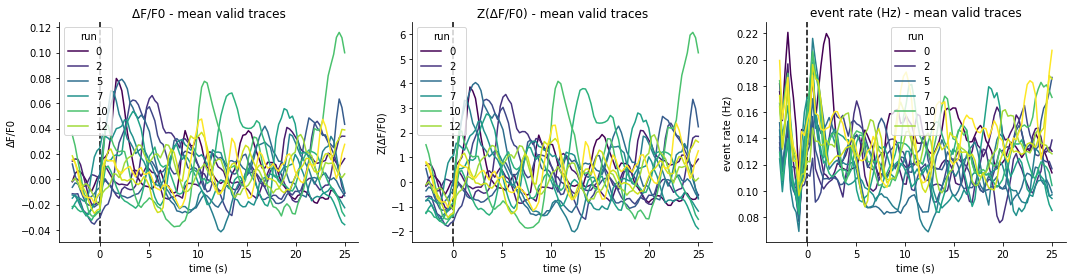

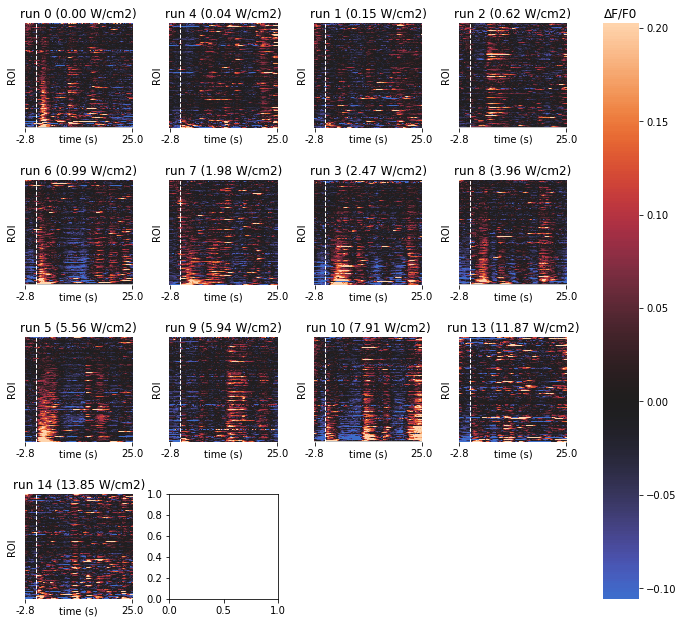

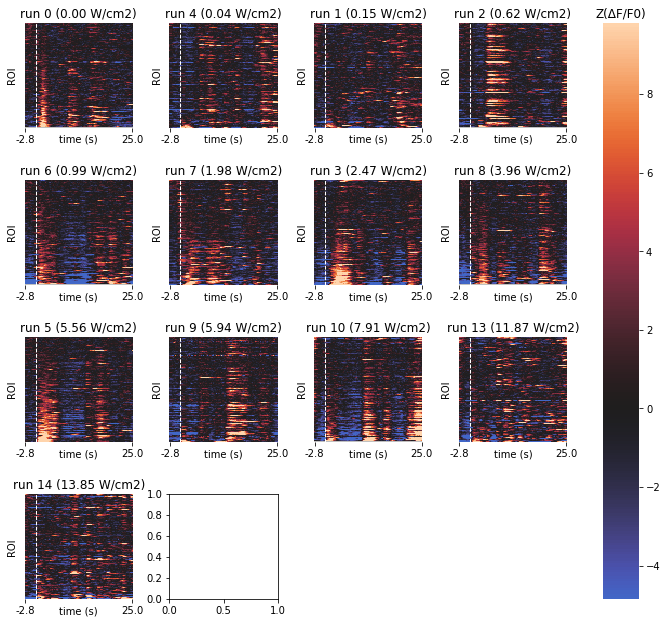

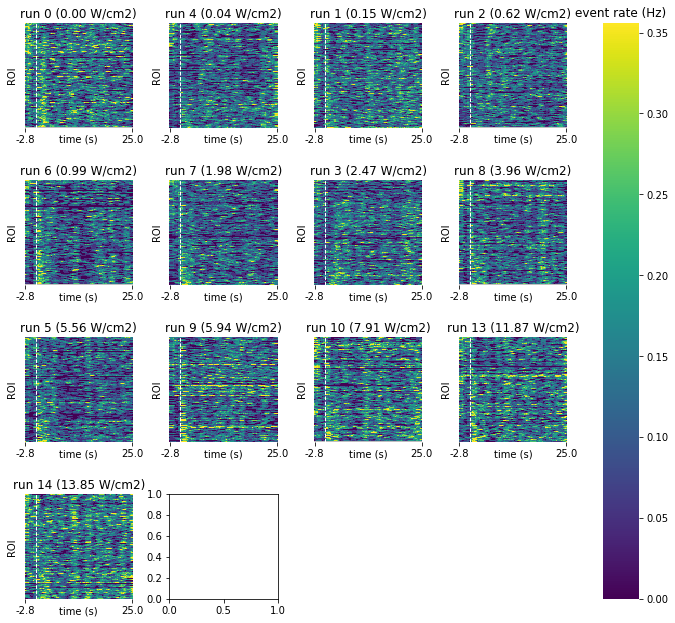

In [32]:
sorted_ISPTAs = trialavg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
ykeys_plt = [Label.DFF, Label.ZSCORE, Label.EVENT_RATE]
figs[f'trial-averaged aggregate traces valid'], axes = plt.subplots(
    1, len(ykeys_plt), figsize=(5 * len(ykeys_plt), 4))
axes = np.atleast_1d(axes)
for ykey, ax in zip(ykeys_plt, axes):
    plot_aggregate_traces(
        trialavg_xtimeseries, fps, ykey, hue=Label.RUN, ax=ax)
    ax.set_title(f'{ykey} - mean valid traces')
    figs[f'{ykey} heatmaps'] = plot_trial_heatmap(
        trialavg_xtimeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        sort_rows=True, 
        rasterized=True)

### Response type, pressure & duty cycle dependency

 04/12/2022 20:20:14: merging timeseries and stats information...
 04/12/2022 20:20:14: adding time info to table...
 04/12/2022 20:20:15: sub-indexing data...
 04/12/2022 20:20:15: filtering data...
 04/12/2022 20:20:15: cross-checking filters...
 04/12/2022 20:20:15: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 04/12/2022 20:20:16: sub-indexing data...
 04/12/2022 20:20:16: filtering data...
 04/12/2022 20:20:16: cross-checking filters...
 04/12/2022 20:20:16: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 04/12/2022 20:20:19: sub-indexing data...
 04/12/2022 20:20:19: filtering data...
 04/12/2022 20:20:19: cross-checking filters...
 04/12/2022 20:20:19: grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 04/12/2022 20:20:20: sub-indexing data...
 04/12/2022 20:20:20: filtering data...
 04/12/2022 20:20:20: cross-checking filters...
 04/12/2022 20:20:20: grouping by DC (%), averaging and plotting mean Z(ΔF/

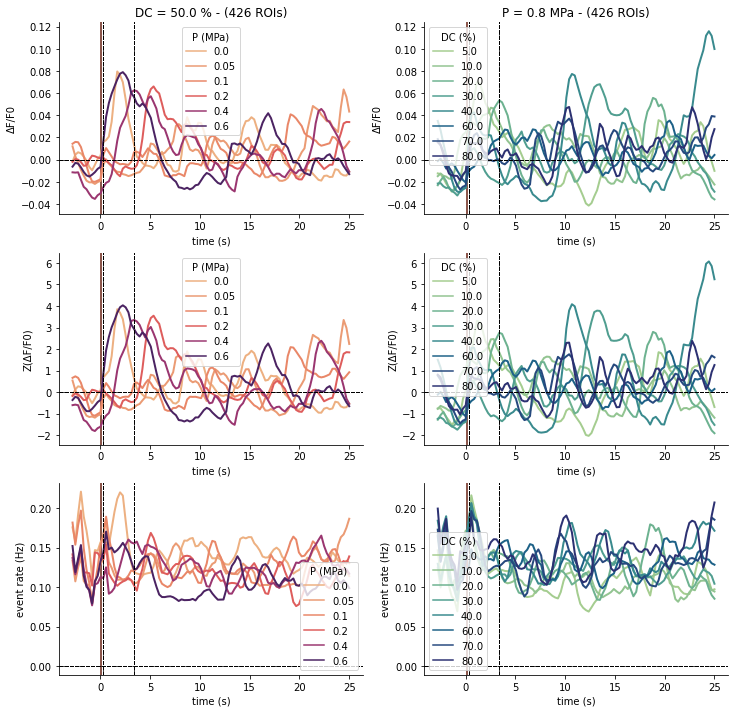

In [33]:
plt_data = get_plot_data(trialavg_xtimeseries, trialavg_stats)
tracekwargs = dict(
    ci=None,
    yref=0.,
)
figs['traces params deps'], axes = plt.subplots(
    len(ykeys_plt), 2, figsize=(12, 4 * len(ykeys_plt)))
for i, (ykey, axrow) in enumerate(zip(ykeys_plt, axes)):
    # Pressure dependency
    plot_responses(
        plt_data, ykey=ykey, DC=DC_REF, hue=Label.P, ax=axrow[0], **tracekwargs)
    # DC dependency
    plot_responses(
        plt_data, ykey=ykey, P=P_REF, hue=Label.DC, ax=axrow[1], **tracekwargs)
    for ax in axrow:
        sns.despine(ax=ax)
        if i > 0:
            ax.set_title(None)
    harmonize_axes_limits(axrow)

### Assess pre-stim and post-stim activity levels, and their differences

 04/12/2022 20:20:49: applying <lambda> function on ΔF/F0 in [0-10] index window across ROI, run ...
 04/12/2022 20:20:50: applying <lambda> function on ΔF/F0 in [11-21] index window across ROI, run ...
 04/12/2022 20:20:51: applying <lambda> function on Z(ΔF/F0) in [0-10] index window across ROI, run ...
 04/12/2022 20:20:52: applying <lambda> function on Z(ΔF/F0) in [11-21] index window across ROI, run ...
 04/12/2022 20:20:53: applying <lambda> function on event rate (Hz) in [0-10] index window across ROI, run ...
 04/12/2022 20:20:54: applying <lambda> function on event rate (Hz) in [11-21] index window across ROI, run ...


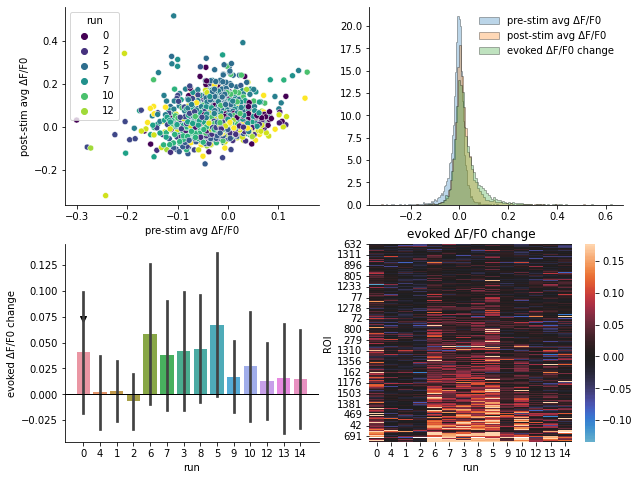

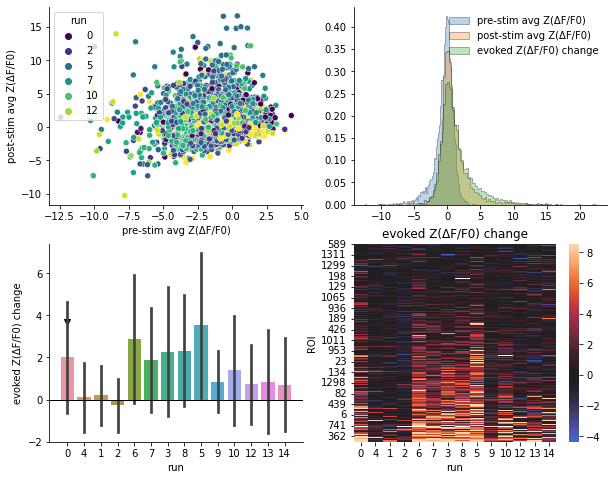

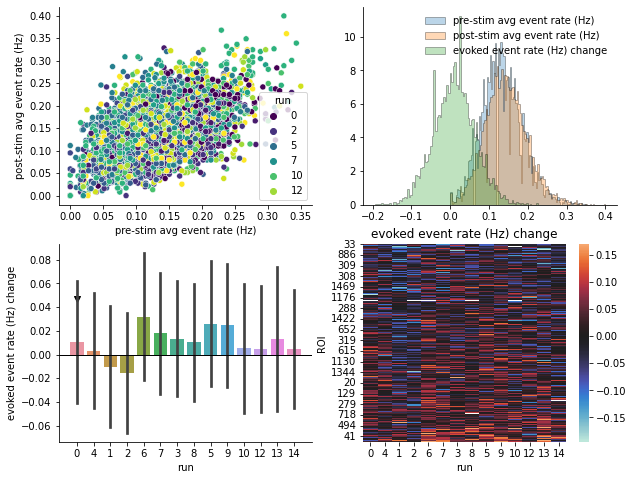

In [34]:
for ykey in ykeys_plt:
    # Get keys for pre, post and change
    ykey_prestim_avg, ykey_poststim_avg, ykey_diff = get_change_key(
        ykey, full_output=True)

    # Compute response average in pre-stimulus and response windows for each ROI & run
    from constants import FrameIndex
    trialavg_stats[ykey_prestim_avg] = apply_in_window(
        lambda x: x.mean(), trialavg_xtimeseries, ykey, FrameIndex.PRESTIM)
    trialavg_stats[ykey_poststim_avg] = apply_in_window(
        lambda x: x.mean(), trialavg_xtimeseries, ykey, FrameIndex.RESPONSE)

    # Compute response strength as their difference
    trialavg_stats[ykey_diff] = trialavg_stats[ykey_poststim_avg] - trialavg_stats[ykey_prestim_avg]

    # Order ROIs by increasing response strength
    ROI_order = trialavg_stats[ykey_diff].groupby(
        Label.ROI).mean().sort_values().index

    # Create figure
    figs[f'{ykey_diff} comp'], axes = plt.subplots(2, 2, figsize=(10, 8))
    for ax in axes.flatten():
        sns.despine(ax=ax)

    # Plot pre-post co-distribution
    sns.scatterplot(
        data=trialavg_stats, x=ykey_prestim_avg, y=ykey_poststim_avg,
        hue=Label.RUN, palette='viridis', legend='auto', ax=axes[0, 0])

    # Plot response strength histogram distributions
    ax = axes[0, 1]
    for ykey in [ykey_prestim_avg, ykey_poststim_avg, ykey_diff]:
        ax.hist(
            trialavg_stats[ykey], label=ykey, bins=100, histtype='stepfilled',
            alpha=0.3, density=True, ec='k')
    ax.legend(frameon=False)

    # Plot response strength vs. run
    ax = axes[1, 0]
    sns.barplot(
        ax=ax, data=trialavg_stats.reset_index(level=Label.RUN),
        x=Label.RUN, y=ykey_diff, order=sorted_ISPTAs.index.values, ci='sd')
    # Add zero line
    ax.axhline(0., c='k', lw=1)
    # Add marker for zero-pressure run
    if irun_P0 is not None:
        irun_P0_ordered = sorted_ISPTAs.index.get_loc(irun_P0)
        ax.scatter(irun_P0_ordered, .5 * ax.get_ylim()[1], marker='v', c='k')

    # Plot response strength heatmap per ROI & run
    ax = axes[1, 1]
    ax.set_title(ykey_diff)
    med = trialavg_stats[ykey_diff].median()
    std = trialavg_stats[ykey_diff].std()
    sns.heatmap(
        trialavg_stats[ykey_diff].unstack().reindex(
            ROI_order, axis=0).reindex(sorted_ISPTAs.index.values, axis=1),
        center=0., ax=ax, vmax=med + 3 * std);

### Identify response type for each ROI & condition using statistical tests on evoked change

 04/12/2022 20:21:08: testing for significant evoked ΔF/F0 change...
 04/12/2022 20:21:17: classifying responses...


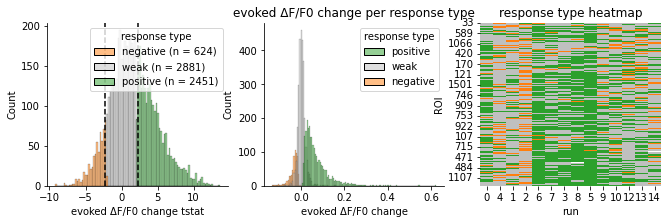

In [35]:
ykey_diff = get_change_key(ykey_classification)

# Test for significant differences pre-post in classification metrics
logger.info(f'testing for significant {ykey_diff}...')
res = trialavg_xtimeseries[ykey_classification].groupby(
    [Label.ROI, Label.RUN]).agg(pre_post_ttest)
res = pd.DataFrame(
    res.tolist(), columns=['tstat', 'pval'],
    index=trialavg_xtimeseries.groupby([Label.ROI, Label.RUN]).first().index)

# Add these fields to trialavg stats
for k in res.columns:
    trialavg_stats[f'{ykey_diff} {k}'] = res[k]

# Classify responses
logger.info('classifying responses...')
trialavg_stats[Label.RESP_TYPE] = (
    (res['pval'] < PTHR_DETECTION).astype(int) * np.sign(res['tstat']).astype(int))

# # Merge negative responses within weak responses
from constants import RTYPE_MAP
# trialavg_stats[Label.RESP_TYPE] = trialavg_stats[Label.RESP_TYPE].replace([-1], [0])
trialavg_stats[Label.RESP_TYPE] = trialavg_stats[Label.RESP_TYPE].map(RTYPE_MAP)
counts_per_rtype = trialavg_stats[Label.RESP_TYPE].value_counts()

# Compute classification threshold t-score
tthr = pvalue_to_tscore(
    PTHR_DETECTION, FrameIndex.RESPONSE.stop - FrameIndex.RESPONSE.start,
    directional=False)

# Create figure
figs['response classification'], axes = plt.subplots(1, 3, figsize=(11, 3))
for ax in axes:
    sns.despine(ax=ax)

# Plot response t-stat histogram per resppnse type
ax = axes[0]
sns.histplot(
    trialavg_stats, x=f'{ykey_diff} tstat', bins=100,
    hue=Label.RESP_TYPE, hue_order=get_default_rtypes(),
    palette=Palette.RTYPE, ax=ax)
ax.axvline(-tthr, ls='--', c='k')
ax.axvline(tthr, ls='--', c='k')
leg = ax.get_legend()
for t in leg.texts:
    s = t.get_text()
    cs = counts_per_rtype.loc[s]
    t.set_text(f'{s} (n = {cs:.0f})')

# Plot response strength histogram with condition type color code
ax = axes[1]
ax.set_title(f'{ykey_diff} per response type')
sns.histplot(
    data=trialavg_stats, x=ykey_diff, ax=ax, 
    hue=Label.RESP_TYPE, palette=Palette.RTYPE)

# Plot response type map per ROI & run
ax = axes[2]
ax.set_title(f'{Label.RESP_TYPE} heatmap')
poscondsmap = trialavg_stats[Label.RESP_TYPE].replace(
    swapdict(RTYPE_MAP)).unstack().reindex(ROI_order, axis=0).reindex(
        sorted_ISPTAs.index.values, axis=1)
sns.heatmap(poscondsmap, ax=ax, cbar=False, cmap=rtype_cmap);

### Identify responding cells based on the number of occurence of each response category

 04/12/2022 20:21:47: cell breakdown:
  - positive: 268 (62.9%)
  - weak: 155 (36.4%)
  - negative: 3 (0.7%)


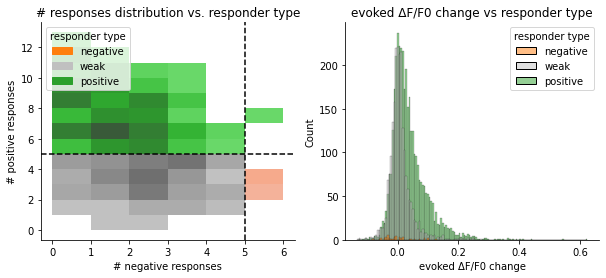

In [36]:
# Compute number of occurences of each response type per ROI
roistats = trialavg_stats[Label.RESP_TYPE].groupby(
    Label.ROI).value_counts().unstack().replace(np.nan, 0.).astype(int)

# Extract type and number of maximum non-null responses, per ROI
nonnullresps = roistats.drop('weak', axis=1).agg(['idxmax', 'max'], axis=1)

# Classify ROIs based on proportion of conditions in each response type
from constants import PROP_CONDS_THR
nconds = len(trialavg_stats.index.unique(level=Label.RUN))
nconds_thr = int(np.round(nconds * PROP_CONDS_THR))
roistats[Label.ROI_RESP_TYPE] = 'weak'
roistats.loc[nonnullresps['max'] >= nconds_thr, Label.ROI_RESP_TYPE] = nonnullresps['idxmax']

# Add roistats to stats and trial-averaged stats
valid_stats = expand_and_add(roistats, valid_stats.copy())
trialavg_stats = expand_and_add(roistats, trialavg_stats.copy())

# Log number and percentage of cells of each responder type identified
ncells_per_type = roistats[Label.ROI_RESP_TYPE].value_counts()
ncells_tot = ncells_per_type.sum()
logstr = []
for rtype, count in ncells_per_type.iteritems():
    logstr.append(f'  - {rtype}: {count} ({count / ncells_tot * 100:.1f}%)')
logstr = "\n".join(logstr)
logger.info(f'cell breakdown:\n{logstr}')

# Create figure
figs['responder classification'], axes = plt.subplots(1, 2, figsize=(10, 4))
for ax in axes:
    sns.despine(ax=ax)

# Plot 2D histogram of # responses of each type per responder category
ax = axes[0]
ax.set_title(f'# responses distribution vs. {Label.ROI_RESP_TYPE}')
ax.set_xlabel('# negative responses')
ax.set_ylabel('# positive responses')
sns.histplot(
    data=roistats, x='negative', y='positive', ax=ax, binwidth=1,
    hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes(), palette=Palette.RTYPE)
ax.axvline(nconds_thr, c='k', ls='--')
ax.axhline(nconds_thr, c='k', ls='--')

# Plot response strength histogram with cell classification
ax = axes[1]
ax.set_title(f'{ykey_diff} vs {Label.ROI_RESP_TYPE}')
sns.histplot(
    data=trialavg_stats, x=ykey_diff, ax=ax,
    hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes(), palette=Palette.RTYPE);

### Save trial-averaged traces and stats to disk

In [37]:
trialavg_dir = get_output_equivalent(
    postpro_dir, 'post-processed', f'trial-averaged/{stats_id}')
trialavg_fpath = os.path.join(trialavg_dir, os.path.basename(postpro_fpath))
map_ops = {
    'micronsPerPixel': um_per_px,
    'Lx': s2p_ops['Lx'],
    'Ly': s2p_ops['Ly'],
    'Vcorr': s2p_ops['Vcorr'],
    'max_proj': s2p_ops['max_proj']
}
save_trialavg_dataset(
    trialavg_fpath, trialavg_xtimeseries, trialavg_stats, ROI_masks, map_ops)

 04/12/2022 20:21:58: saving trial-averaged timeseries data...
 04/12/2022 20:21:58: saving trial-averaged stats data...
 04/12/2022 20:21:58: saving ROI masks...
 04/12/2022 20:21:58: saving mapping options...


/gpfs/data/shohamlab/theo/code/usnm2p/fileops.py:599: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  store['map_ops'] = pd.Series(map_ops)


## Results visualization

Several key analysis outputs are visualized:
- summary of the neural populations per responder type & their spatial distribution across the field of view
- parameter-dependency of response metrics for each responder type.
- parameter-dependent aggregate traces of activity metrics (ΔF/F0 and event rate) for each  responder type

### Dataset summary

 04/12/2022 20:22:01: extracting responses types per ROI...
 04/12/2022 20:22:01: plotting cells map color-coded by response type...


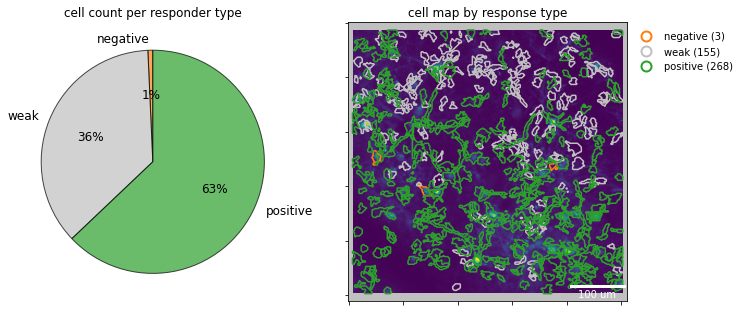

In [38]:
# Count cells by responder type
counts_by_rtype = (
    trialavg_stats
    .groupby(Label.ROI)[Label.ROI_RESP_TYPE].first()
    .value_counts()
    .reindex(get_default_rtypes())
    .fillna(0)
)

# Create figure
figs['dataset summary'], axes = plt.subplots(1, 2, figsize=(11, 6))

# Plot counts on pie chart
ax = axes[0]
ax.set_title('cell count per responder type')
counts_by_rtype.plot.pie(
    ax=ax, ylabel='', autopct='%1.0f%%',
    colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
    startangle=90, textprops={'fontsize': 12}, 
    wedgeprops={'edgecolor': 'k', 'alpha': 0.7})

# Spatial distribution of cells per response type
plot_cell_map(
    ROI_masks, trialavg_stats, map_ops, title='cell map by response type',
    um_per_px=um_per_px, refkey='max_proj', mode='contour', ax=axes[1]);

### Response strength parameter dependency per responder type

 04/12/2022 20:22:05: sub-indexing data...
 04/12/2022 20:22:05: filtering data...
 04/12/2022 20:22:05: cross-checking filters...
 04/12/2022 20:22:05: grouping by responder type, averaging, estimating confidence intervals and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 04/12/2022 20:22:05: sub-indexing data...
 04/12/2022 20:22:05: filtering data...
 04/12/2022 20:22:05: cross-checking filters...
 04/12/2022 20:22:05: grouping by responder type, averaging, estimating confidence intervals and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 04/12/2022 20:22:06: sub-indexing data...
 04/12/2022 20:22:06: filtering data...
 04/12/2022 20:22:06: cross-checking filters...
 04/12/2022 20:22:06: grouping by responder type, averaging, estimating confidence intervals and plotting mean evoked Z(ΔF/F0) change vs. P (MPa) ...
 04/12/2022 20:22:07: sub-indexing data...
 04/12/2022 20:22:07: filtering data...
 04/12/2022 20:22:07: cross-checking filters...
 04/12/2022 20:22:07: grouping by

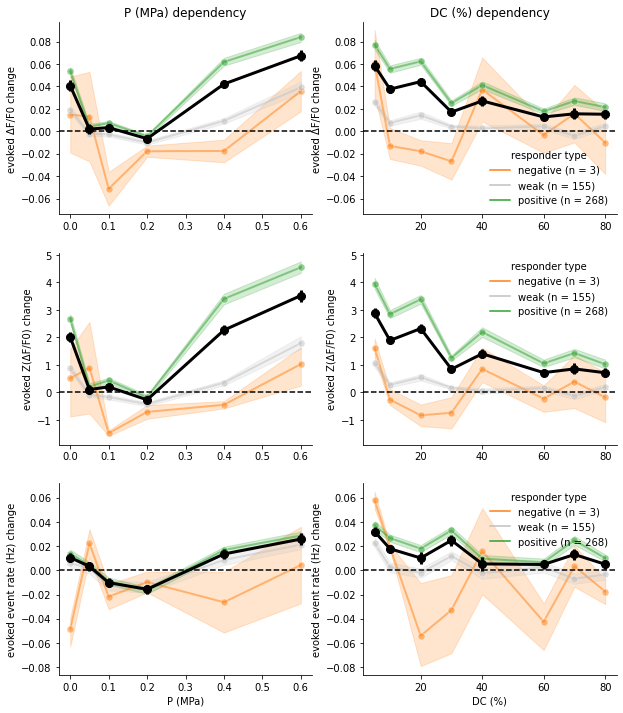

In [39]:
figs[f'stimparams dependency per rtype'], axes = plt.subplots(
    len(ykeys_plt), 2, figsize=(10, 4 * len(ykeys_plt)))
for ykey, axrow in zip(ykeys_plt, axes):
    ykey_diff = get_change_key(ykey)
    plot_stimparams_dependency(
        trialavg_stats, ykey_diff, yref=0, hue=Label.ROI_RESP_TYPE, palette=Palette.RTYPE,
        avgprop='whue', errprop='intra', axes=axrow)
for axrow in axes[1:]:
    for ax in axrow:
        ax.set_title(None)
for axrow in axes[:-1]:
    for ax in axrow:
        ax.set_xlabel(None)

### Response type, pressure & duty cycle dependency, per category

 04/12/2022 20:23:21: merging timeseries and stats information...
 04/12/2022 20:23:23: adding time info to table...
 04/12/2022 20:23:23: sub-indexing data...
 04/12/2022 20:23:23: filtering data...
 04/12/2022 20:23:23: cross-checking filters...
 04/12/2022 20:23:23: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 04/12/2022 20:23:25: sub-indexing data...
 04/12/2022 20:23:25: filtering data...
 04/12/2022 20:23:25: cross-checking filters...
 04/12/2022 20:23:25: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 04/12/2022 20:23:29: sub-indexing data...
 04/12/2022 20:23:29: filtering data...
 04/12/2022 20:23:29: cross-checking filters...
 04/12/2022 20:23:29: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 04/12/2022 20:23:32: sub-indexing data...
 04/12/2022 20:23:32: filtering data...
 04/12/2022 20:23:32: cross-checking fi

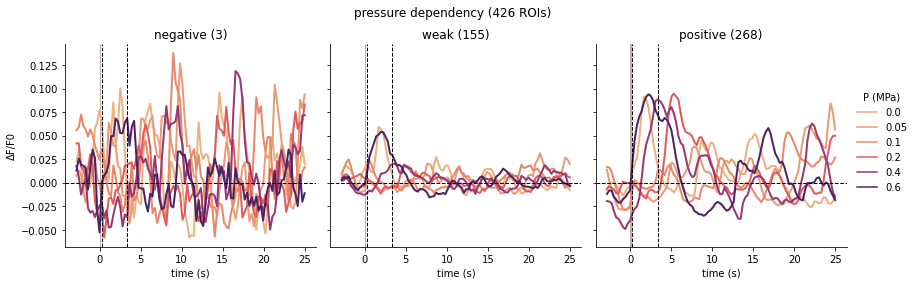

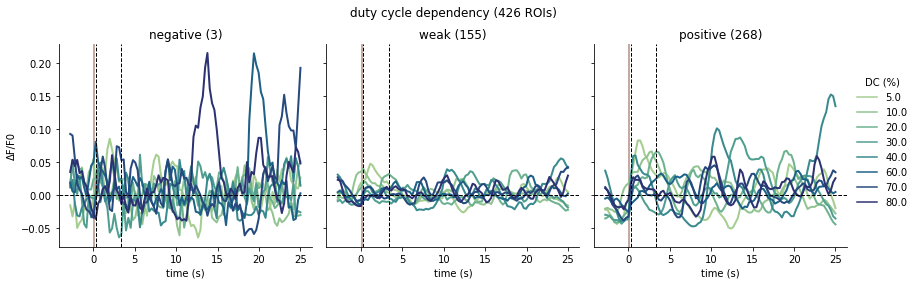

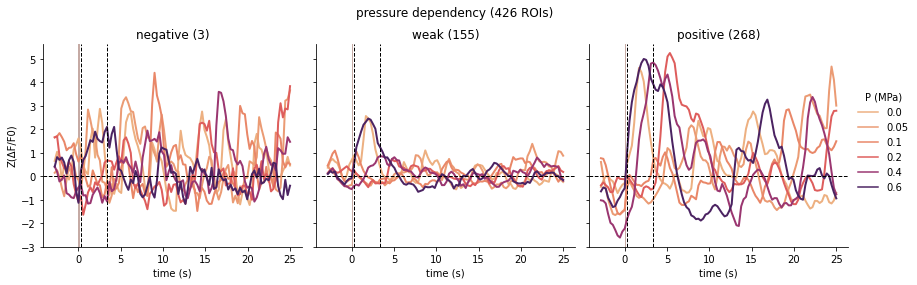

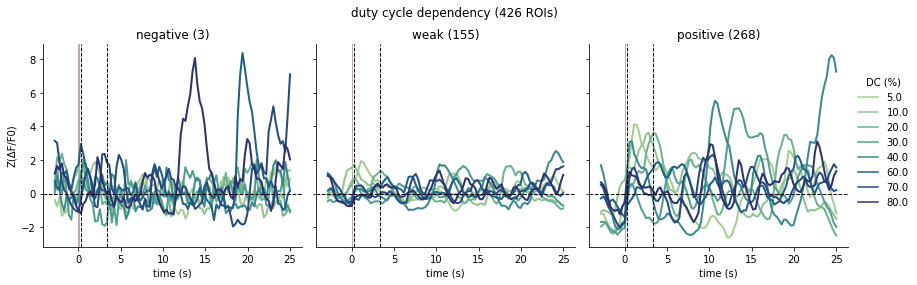

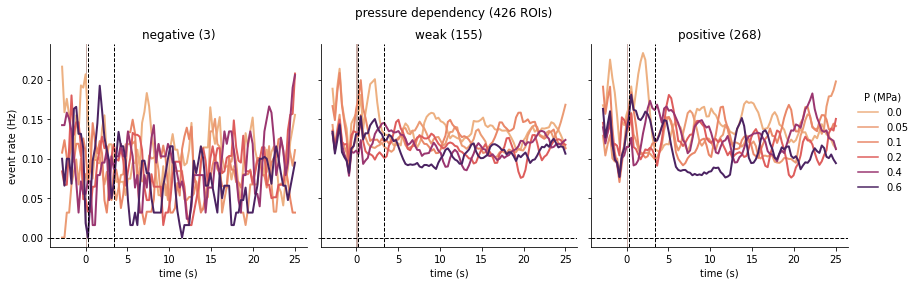

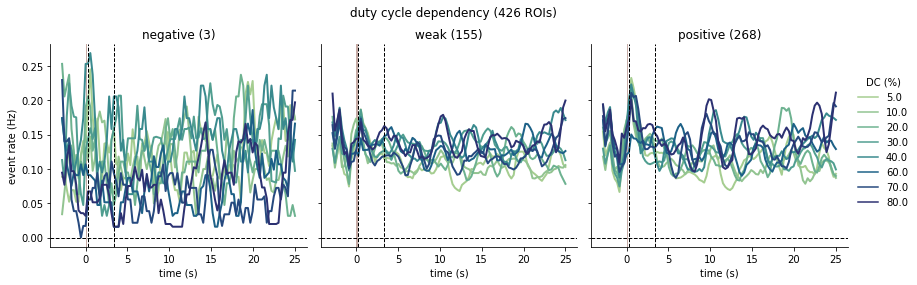

In [40]:
plt_data = get_plot_data(trialavg_xtimeseries, trialavg_stats)
nROIs = len(trialavg_stats.index.unique(level=Label.ROI))
tracekwargs = dict(
    height = 4,  # height of each figure axis
    aspect = 1.,  # width / height aspect ratio of each axis
    hide_col_prefix = True,
    col_count_key = Label.ROI,
    ci=None,
    yref=0.
)
for ykey in ykeys_plt:
    # Pressure dependency
    figs[f'{ykey} traces by type DC={DC_REF}%'] = plot_responses(
        plt_data, ykey=ykey, DC=DC_REF, hue=Label.P, 
        col=Label.ROI_RESP_TYPE, title=f'pressure dependency ({nROIs} ROIs)', **tracekwargs)
    # Duty cycle dependency
    figs[f'{ykey} traces by type P={P_REF}MPa'] = plot_responses(
        plt_data, ykey=ykey, P=P_REF, hue=Label.DC, 
        col=Label.ROI_RESP_TYPE, title=f'duty cycle dependency ({nROIs} ROIs)', **tracekwargs)

### Save figures

In [107]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figssuffix)

# Save stacks as GIFs if specified
if irun_inspect is not None and save_gifs:
    #raw and fileted stacks from specific run
    save_stack_to_gif(
        figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run)
    # registered stack (slice corresponding to specific run)
    save_stack_to_gif(
        figsdir, s2p_ops, title=outstack_label,
        ilabels=istimframes_stacked, bounds=runbounds)

 04/12/2022 19:59:30: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.12.04/figs_line3_20191112_mouse12_region1_k0.5_alpha0.7_qadaptive_wq10.0s_classΔFF0.pdf:


100%|██████████| 46/46 [00:14<00:00,  3.14it/s]


### Notify upon completion

In [108]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{dataset_id} notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 04/12/2022 19:59:45: 20191112_mouse12_region1 notebook completed in 0:53:51.268679 s
